In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

## Setup

In [2]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats, interpolate
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy
import networkx as nx

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath

figDPI = 100

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 30}

plt.rc('font', **font)

# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

We recast the number of groups as a float so that we can use NaNs for days with missing observations.

In [3]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1.22.csv', quotechar = '"', encoding = 'ansi',header = 15)

GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)
GN_Dat

YEAR  MONTH  DAY  ORDINAL  STATION  OBSERVER  GROUPS     FRACYEAR
0        1610      1    1   587676        0         0    -1.0  1610.000000
1        1610      1    2   587677        0         0    -1.0  1610.002740
2        1610      1    3   587678        0         0    -1.0  1610.005479
3        1610      1    4   587679        0         0    -1.0  1610.008219
4        1610      1    5   587680        0         0    -1.0  1610.010959
5        1610      1    6   587681        0         0    -1.0  1610.013699
6        1610      1    7   587682        0         0    -1.0  1610.016438
7        1610      1    8   587683        0         0    -1.0  1610.019178
8        1610      1    9   587684        0         0    -1.0  1610.021918
9        1610      1   10   587685        0         0    -1.0  1610.024658
10       1610      1   11   587686        0         0    -1.0  1610.027397
11       1610      1   12   587687        0         0    -1.0  1610.030137
12       1610      1   13   587688        0         0    -1.0  1610.032877
13       1610      1   14   587689        0         0    -1.0  1610.035616
14       1610      1   15   587690        0         0    -1.0  1610.038356
15       1610      1   16   587691        0         0    -1.0  1610.041096
16       1610      1   17   587692        0         0    -1.0  1610.043836
17       1610      1   18   587693        0         0    -1.0  1610.046575
18       1610      1   19   587694        0         0    -1.0  1610.049315
19       1610      1   20   587695        0         0    -1.0  1610.052055
20       1610      1   21   587696        0         0    -1.0  1610.054795
21       1610      1   22   587697        0         0    -1.0  1610.057534
22       1610      1   23   587698        0         0    -1.0  1610.060274
23       1610      1   24   587699        0         0    -1.0  1610.063014
24       1610      1   25   587700        0         0    -1.0  1610.065753
25       1610      1   26   587701        0         0    -1.0  1610.068493
26       1610      1   27   587702        0         0    -1.0  1610.071233
27       1610      1   28   587703        0         0    -1.0  1610.073973
28       1610      1   29   587704        0         0    -1.0  1610.076712
29       1610      1   30   587705        0         0    -1.0  1610.079452
...       ...    ...  ...      ...      ...       ...     ...          ...
1100206  2010     12   30   734136      698         1     1.0  2010.994521
1100207  2010     12   30   734136      708         1     1.0  2010.994521
1100208  2010     12   30   734136      713         1     2.0  2010.994521
1100209  2010     12   30   734136      714         1     2.0  2010.994521
1100210  2010     12   31   734137      502         1     3.0  2010.997260
1100211  2010     12   31   734137      511         1     3.0  2010.997260
1100212  2010     12   31   734137      522         1     5.0  2010.997260
1100213  2010     12   31   734137      540         1     3.0  2010.997260
1100214  2010     12   31   734137      550         1     2.0  2010.997260
1100215  2010     12   31   734137      552         1     4.0  2010.997260
1100216  2010     12   31   734137      558         1     3.0  2010.997260
1100217  2010     12   31   734137      568         1     0.0  2010.997260
1100218  2010     12   31   734137      589         1     3.0  2010.997260
1100219  2010     12   31   734137      592         1     3.0  2010.997260
1100220  2010     12   31   734137      597         1     4.0  2010.997260
1100221  2010     12   31   734137      602         1     4.0  2010.997260
1100222  2010     12   31   734137      606         1     4.0  2010.997260
1100223  2010     12   31   734137      614         1     2.0  2010.997260
1100224  2010     12   31   734137      615         1     3.0  2010.997260
1100225  2010     12   31   734137      616         1     2.0  2010.997260
1100226  2010     12   31   734137      627         1     2.0  2010.997260
1100227  2010     12   31   734137

## Reading observers

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

The **_print_** statement on this cell can be use for reference as it shows the station number associated with each observer.

In [4]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1.22.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     INITIAL   FINAL  STATION                                   OBSERVER  TOT.OBS
0     1610.0  1613.0        1                        HARRIOT, T., OXFORD      210
1     1611.0  1640.0        2                         SCHEINER, C., ROME      882
2     1612.0  1612.0        3                          GALILEO, G., ROME       51
3     1612.0  1612.0        4                      GALILEO-SAKURAI, ROME       37
4     1612.0  1612.0        5                      COLOGNA, S., MONREALE       20
5     1612.0  1613.0        6                       JUNGIUS, J., HAMBURG      104
6     1612.0  1612.0        7                         CIGOLI, L.C., ROME       29
7     1613.0  1614.0        8                        COLONNA, F., NAPLES       51
8     1615.0  1617.0        9                          TARDE, J., FARLAT       57
9     1616.0  1616.0       10                    SAXONIUS, P., NUREMBERG       12
10       NaN     NaN       11                      MARIUS, S., NUREMBERG        0
11    1618.0  16

## Reading Sunspot Group Number Data

In [27]:
JV_Dat = pd.read_csv('input_data/Vaquero_Uncertainty.csv', quotechar = '"', encoding = 'ansi')
# Adding 0.5 years to Jose's data to match the other people's standards
JV_Dat['Year'] = JV_Dat['Year']+0.5
# Combining limits to create a single S
JV_Dat['S'] = (JV_Dat['S2'] + JV_Dat['S1'])/2
JV_Dat = JV_Dat.loc[:,['Year','G','S','S1','S2']]

# Interpolating Nadya's data to half years
# High
NZH_Dat = pd.read_csv('input_data/Zolotova_high.csv', quotechar = '"', encoding = 'ansi')
NZH_Dat = NZH_Dat.sort_values('Date')

NZ_int = interpolate.splrep(NZH_Dat['Date'].values, NZH_Dat['G'].values, s=1)
yr = np.arange(np.floor(np.min(NZH_Dat['Date'])),np.ceil(np.max(NZH_Dat['Date'])))+0.5
G = interpolate.splev(yr, NZ_int)
# Create new Zolotova database
NZH_Dat = pd.DataFrame(data={'Date': yr, 'G': G})

# Low
NZL_Dat = pd.read_csv('input_data/Zolotova_low.csv', quotechar = '"', encoding = 'ansi')
NZL_Dat = NZL_Dat.sort_values('Date')

NZ_int = interpolate.splrep(NZL_Dat['Date'].values, NZL_Dat['G'].values, s=7)
yr = np.arange(np.floor(np.min(NZL_Dat['Date'])),np.ceil(np.max(NZL_Dat['Date'])))+0.5
G = interpolate.splev(yr, NZ_int)
# Create new Zolotova database
NZL_Dat = pd.DataFrame(data={'Date': yr, 'G': G})

# Mixed
yr = np.intersect1d(NZH_Dat['Date'],NZL_Dat['Date'])
G = (NZH_Dat.loc[np.logical_and(NZH_Dat['Date']>=np.min(yr),NZH_Dat['Date']<=np.max(yr)),'G'] +
     NZL_Dat.loc[np.logical_and(NZL_Dat['Date']>=np.min(yr),NZL_Dat['Date']<=np.max(yr)),'G'] )/2

S = (NZH_Dat.loc[np.logical_and(NZH_Dat['Date']>=np.min(yr),NZH_Dat['Date']<=np.max(yr)),'G'] -
     NZL_Dat.loc[np.logical_and(NZL_Dat['Date']>=np.min(yr),NZL_Dat['Date']<=np.max(yr)),'G'] )/2

MS = np.mean(np.abs((NZH_Dat.loc[np.logical_and(NZH_Dat['Date']>=np.min(yr),NZH_Dat['Date']<=1670),'G'] -
     NZL_Dat.loc[np.logical_and(NZL_Dat['Date']>=np.min(yr),NZL_Dat['Date']<=1670),'G'] )/2))

S[S<MS] = MS

NZM_Dat = pd.DataFrame(data={'Date': yr, 'G': G, 'S':G*0+S})



SS_Dat = pd.read_csv('input_data/GNbb2_y.csv', quotechar = '"', encoding = 'ansi')
# Removing zero uncertainties
SS_Dat.loc[SS_Dat['S']==0,'S'] = np.min(SS_Dat.loc[SS_Dat['S']!=0,'S'])

U_Dat = pd.read_csv('input_data/GNiu_y2.csv', quotechar = '"', encoding = 'ansi')
U_Dat = U_Dat.loc[:,['Year','G','S']]
# Removing zero uncertainties
U_Dat.loc[U_Dat['S']==0,'S'] = np.min(U_Dat.loc[U_Dat['S']!=0,'S'])



HS_Dat = pd.read_csv('input_data/GNhs_y.csv', quotechar = '"', encoding = 'ansi')
# Changing the uncertainty of HS for the one in SS
HS_Dat['S'] = SS_Dat.loc[0:HS_Dat.shape[0],'S']

LO_Dat = pd.read_csv('input_data/Lockwood_etal_2014.csv', quotechar = '"', encoding = 'ansi')
# Changing the uncertainty of HS for the one in SS
LO_Dat['S'] = SS_Dat.loc[0:LO_Dat.shape[0],'S']
# Re-scaling to group number
LO_Dat['G'] = LO_Dat['G']/12.08


WSN_Dat = pd.read_csv('input_data/SN_y_tot_V2.0.csv', quotechar = '"', encoding = 'ansi')
WSN_Dat = WSN_Dat.loc[:,['Year','G','S']]
# Removing zero uncertainties
WSN_Dat.loc[WSN_Dat['S']<=0,'S'] = np.min(WSN_Dat.loc[WSN_Dat['S']!=0,'S'])
# Re-scaling to group number
WSN_Dat['G'] = WSN_Dat['G']/20
WSN_Dat['S'] = WSN_Dat['S']/20

Ch_Dat = pd.read_csv('input_data/Chatzistergos.csv', quotechar = '"', encoding = 'ansi')
Ch_Dat['S'] = (Ch_Dat['S2'] + Ch_Dat['S1'])/2

IM_Dat = pd.read_csv('input_data/Ivanov_Miletsky.csv', quotechar = '"', encoding = 'ansi')
IM_Dat['Year'] = IM_Dat['Year']+0.5


CL_Dat = pd.read_csv('input_data/Cliver_ling_2016.csv', quotechar = '"', encoding = 'ansi')
CL_Dat['Year'] = CL_Dat['Year']+0.5
CL_Dat['G'] = CL_Dat['RGC']/12.08

# Changing the uncertainty of CL for the one in SS
CL_Dat['S'] = SS_Dat.loc[231:370,'S'].values
U_Dat

Year       G      S
0    1749.5   7.017  0.797
1    1750.5   6.043  0.878
2    1751.5   4.500  1.558
3    1752.5   2.970  0.453
4    1753.5   3.227  0.823
5    1754.5   1.138  0.151
6    1755.5   0.775  0.144
7    1756.5   0.925  0.098
8    1757.5   2.055  0.281
9    1758.5   3.346  0.219
10   1759.5   4.325  1.247
11   1760.5   4.928  0.717
12   1761.5   6.658  0.653
13   1762.5   4.942  0.449
14   1763.5   3.846  0.477
15   1764.5   2.970  0.449
16   1765.5   1.439  0.265
17   1766.5   1.091  0.189
18   1767.5   3.464  0.476
19   1768.5   7.028  0.747
20   1769.5   9.028  0.703
21   1770.5   8.568  0.642
22   1771.5   7.259  0.799
23   1772.5   6.279  0.562
24   1773.5   3.259  0.479
25   1774.5   3.156  0.618
26   1775.5   1.111  0.108
27   1776.5   1.447  0.222
28   1777.5   7.603  1.036
29   1778.5   8.718  1.400
..      ...     ...    ...
217  1966.5   3.635  0.024
218  1967.5   7.934  0.049
219  1968.5   8.129  0.041
220  1969.5   7.947  0.043
221  1970.5   8.968  0.048
222  1971.5   6.081  0.033
223  1972.5   5.955  0.037
224  1973.5   3.235  0.024
225  1974.5   2.824  0.024
226  1975.5   1.252  0.016
227  1976.5   1.122  0.013
228  1977.5   2.498  0.021
229  1978.5   8.489  0.055
230  1979.5  12.900  0.061
231  1980.5  11.696  0.053
232  1981.5  11.677  0.062
233  1982.5   9.611  0.048
234  1983.5   5.940  0.040
235  1984.5   3.640  0.027
236  1985.5   1.402  0.016
237  1986.5   1.004  0.011
238  1987.5   2.295  0.020
239  1988.5   7.400  0.054
240  1989.5  12.233  0.065
241  1990.5  12.310  0.074
242  1991.5  12.085  0.058
243  1992.5   7.939  0.043
244  1993.5   4.452  0.023
245  1994.5   2.952  0.023
246  1995.5   1.566  0.010

[247 rows x 3 columns]

## Reading Butterfly Diagram Data

In [6]:
BflyMM = pd.read_csv('input_data/Sunspot_Latitudes_MM.csv', quotechar = '"', encoding = 'ansi',header=14)
BflyMod = pd.read_csv('input_data/composite_bfly_all.csv', quotechar = '"', encoding = 'ansi')
BflyMod['ORDINAL'] = BflyMod.apply(lambda x: datetime.date(int(x['YEAR']),int(x['MONTH']),int(x['DAY'])).toordinal(),axis=1)

BflyMM1 = pd.read_csv('input_data/Bfly_Gissendi_Malapert_Macgraf.csv', quotechar = '"', encoding = 'ansi')

BflyHrt = pd.read_csv('input_data/Bfly_harriot.csv', quotechar = '"', encoding = 'ansi')
BflyHrt['ORDINAL'] = BflyHrt.apply(lambda x: datetime.date(int(x['Year']),int(x['Month']),int(x['Day'])).toordinal(),axis=1)
BflyHrt['FRACYEAR'] = BflyHrt.apply(lambda x: x['Year'].astype(int)
                                            + (  datetime.date(x['Year'].astype(int),x['Month'].astype(int),x['Day'].astype(int)).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['Year'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                  ,axis=1)


# BflyGal = pd.read_csv('input_data/Bfly_Galileo.csv', quotechar = '"', encoding = 'ansi')
BflyGal = pd.read_csv('input_data/Bfly_Galileo_Zolotova.csv', quotechar = '"', encoding = 'ansi')

BflyGal['ORDINAL'] = BflyGal.apply(lambda x: datetime.date(int(x['Year']),int(x['Month']),int(x['Day'])).toordinal(),axis=1)
BflyGal['FRACYEAR'] = BflyGal.apply(lambda x: x['Year'].astype(int)
                                            + (  datetime.date(x['Year'].astype(int),x['Month'].astype(int),x['Day'].astype(int)).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['Year'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                  ,axis=1)

BflyHvl = pd.read_csv('input_data/Bfly_hevelius_JV.csv', quotechar = '"', encoding = 'ansi')

BflySchn = pd.read_csv('input_data/Bfly_scheiner.csv', quotechar = '"', encoding = 'ansi')
BflySchn['ORDINAL'] = BflySchn.apply(lambda x: datetime.date(int(x['Year']),int(x['Month']),int(x['Day'])).toordinal(),axis=1)
BflySchn['FRACYEAR'] = BflySchn.apply(lambda x: x['Year'].astype(int)
                                            + (  datetime.date(x['Year'].astype(int),x['Month'].astype(int),x['Day'].astype(int)).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['Year'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                  ,axis=1)


BflyStdc = pd.read_csv('input_data/Bfly_staudacher.csv', quotechar = '"', encoding = 'ansi')
BflyStdc['ORDINAL'] = BflyStdc.apply(lambda x: datetime.date(int(x['Year']),int(x['Month']),int(x['Day'])).toordinal(),axis=1)
BflyStdc['FRACYEAR'] = BflyStdc.apply(lambda x: x['Year'].astype(int)
                                            + (  datetime.date(x['Year'].astype(int),x['Month'].astype(int),x['Day'].astype(int)).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['Year'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['Year'].astype(int),1,1).toordinal() )
                                  ,axis=1)

BflyGal

Year  Month  Day  Hour  Minute  Area      R   Sp   G  Longitude  \
0    1612      5    3  13.0    18.0   105  38.90    2   2      39.63   
1    1612      5    3  13.0    18.0   144  43.26    3   2      34.53   
2    1612      5    3  13.0    18.0   193  36.58    4   3     102.20   
3    1612      5    3  13.0    18.0   163  27.55    5   4      87.57   
4    1612      5    3  13.0    18.0   151  26.86    6   4      82.64   
5    1612      5    3  13.0    18.0   223   4.05    7   5      72.29   
6    1612      5    3  13.0    18.0    94   7.69    8   5      67.68   
7    1612      5    3  13.0    18.0   130  34.94    9   6      50.49   
8    1612      5    3  13.0    18.0    58  36.87   10   6      46.22   
9    1612      5    3  13.0    18.0   263  54.24   11   7      18.05   
10   1612      5    3  13.0    18.0   260  56.77   12   7      15.56   
11   1612      5    3  13.0    18.0   314  56.27   13   7      15.95   
12   1612      5    3  13.0    18.0   412  63.83   14   8       8.35   
13   1612      5    3  13.0    18.0   373  66.20   15   8       5.91   
14   1612      5    3  13.0    18.0   684  71.03   16   9       1.44   
15   1612      5    4   NaN     NaN  2999  33.71    1   1      85.59   
16   1612      5    4   NaN     NaN    56  31.61    2   2      37.11   
17   1612      5    4   NaN     NaN    74  34.06    3   2      33.98   
18   1612      5    4   NaN     NaN   163  43.96    4   3      99.03   
19   1612      5    4   NaN     NaN   175  35.57    5   4      85.34   
20   1612      5    4   NaN     NaN    66  36.02    6   4      83.18   
21   1612      5    4   NaN     NaN   123  16.17    7   5      73.57   
22   1612      5    4   NaN     NaN    78  12.85    8   5      70.28   
23   1612      5    4   NaN     NaN   111  25.67    9   6      50.11   
24   1612      5    4   NaN     NaN   102  28.88   10   6      46.40   
25   1612      5    4   NaN     NaN   218  37.32   11   7      20.29   
26   1612      5    4   NaN     NaN   126  39.68   12   7      17.89   
27   1612      5    4   NaN     NaN   176  38.01   13   7      19.54   
28   1612      5    4   NaN     NaN   135  47.08   14   8      10.44   
29   1612      5    4   NaN     NaN    47  46.55   15   8      11.03   
..    ...    ...  ...   ...     ...   ...    ...  ...  ..        ...   
530  1612      8   19  15.0    14.0   251  25.02  134  72     100.14   
531  1612      8   19  15.0    14.0  2203   4.11  135  73      82.82   
532  1612      8   19  15.0    14.0   653  26.43  136  74      56.70   
533  1612      8   19  15.0    14.0    81  50.53  137  75      33.66   
534  1612      8   19  15.0    14.0   304  56.28  138  76     132.95   
535  1612      8   19  15.0    14.0   170  45.77  139  77     121.43   
536  1612      8   19  15.0    14.0    63  38.48  140  78     110.61   
537  1612      8   20  13.0    33.0   214  71.79  131  70     143.03   
538  1612      8   20  13.0    33.0   211  67.12  132  71     137.78   
539  1612      8   20  13.0    33.0   257  37.64  133  72     107.02   
540  1612      8   20  13.0    33.0   212  34.72  134  72     100.23   
541  1612      8   20  13.0    33.0   153  36.66  141  72     104.39   
542  1612      8   20  13.0    33.0  2293  11.81  135  73      81.01   
543  1612      8   20  13.0    33.0   385  16.45  136  74      55.83   
544  1612      8   20  13.0    33.0   153  43.48  137  75      31.02   
545  1612      8   20  13.0    33.0   191  70.60  138  76     136.65   
546  1612      8   20  13.0    33.0    81  59.61  139  77     124.77   
547  1612      8   20  13.0    33.0   100  50.65  140  78     114.08   
548  1612      8   20  13.0    33.0   526  62.76  142  79       6.54   
549  1612      8   21  16.0    27.0   236  48.45  133  72     103.86   
550  1612      8   21  16.0    27.0    93  44.78  134  72      97.91   
551  1612      8   21  16.0    27.0  1560  22.46  135  73      77.58   
552  1612      8   21  16.0    27.0    86   9.01  136  74      51.72   
553  1612      8   21  16.0    27.0    24  32

## Pre-allocating Variables

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

In [7]:
UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]
UnObs.shape

(715,)

### Day adjacency tolerance

Since the amount of groups visible in the Sun don't change radically from day to day, we specify a window of tolerance in which two observations are considered to be _"simultaneous"_.  First priority is given to observations taken on the same calendar date, then to observations within one day are considered, then within two days, and so on until reaching the size of the tolerance window.  The process is ran simultaneously for prior and following days.

In [8]:
DayTol = 2

### Minimum days of overlap

In order to establish a link between two observers in the network, we require to have minimum amount of days of overlap (considering as overlapping days days within DayTol of each other).

In [9]:
MinOvr = 60

## Creating the adjacency matrix

Now we go through all observers **_(stations)_** executing the following algorithm:

1. Pick an observer _(station)_.
2. Find all observers _(stations)_ that have overlapping observations within DayTol.
3. Go through all overlaping observers _(stations)_ and define the adjacency matrices.

In [10]:
# Minimum number of different group numbers to consider an observer valid
minObVal = 4

#Number of days of overlap
LnkDays = sp.sparse.lil_matrix((UnObs.shape[0], UnObs.shape[0]))

pos = {} #Dictionary with positions for plotting the network
for iObs1 in range(UnObs.shape[0]):

    #---------------------
    # 1. Pick an observer    
    #---------------------
    
    Obs1 = GN_Dat[GN_Dat['STATION'] == UnObs[iObs1]]
    
    #Update position dictionary of for plotting
    pos.update({iObs1: [ sp.mean(Obs1.FRACYEAR), sp.random.random_sample()]})
    
    # Create an array of valid date of observations including +/- DayTol
    DatObs1 = Obs1.ORDINAL
    TmpList = DatObs1
    for iDat in range(DayTol):
        TmpList = pd.concat([TmpList,DatObs1 + iDat + 1])
        TmpList = pd.concat([TmpList,DatObs1 - iDat - 1])    
    DatObs1 = sp.unique(TmpList)

    
    #---------------------
    # 2. Find all observers that have overlapping observations within DayTol
    #---------------------
    
    ObsOvrlp = sp.in1d(GN_Dat.ORDINAL, DatObs1)
    ObsOvrlp = sp.unique(GN_Dat.STATION[ObsOvrlp])
    ObsOvrlp = ObsOvrlp[sp.logical_and(ObsOvrlp != 0, ObsOvrlp != UnObs[iObs1])]
    
    # Void observer if it doesn't have enough values
    if np.unique(Obs1['GROUPS']).shape[0] < minObVal:
        ObsOvrlp = np.array([]) 
    
    #---------------------
    # 3. Go through all overlaping observers and define the adjacency matrices.
    #---------------------
    
    for iObsOvrlp in range(ObsOvrlp.shape[0]):
        
        #Determine the overlapping observer
        iObs2 = (UnObs==ObsOvrlp[iObsOvrlp]).nonzero()
        Obs2 = GN_Dat[GN_Dat.STATION == ObsOvrlp[iObsOvrlp]]
        
        # Remove zeros to include only matches that could potentially signify a useful connection
        #Obs2 = Obs2[Obs2['GROUPS'] > 0]
        
        DatObs2 = Obs2.ORDINAL
        
        
        # Void observer if it doesn't have enough values
        if np.unique(Obs2['GROUPS']).shape[0] < minObVal:
            DatObs2 = np.array([])        
        
        #Find the dates in common (including days within DayTol)
        DatIntrsct = sp.intersect1d(DatObs1,DatObs2)
        
        #Fill the days of overlap adjacency matrix
        if DatIntrsct.shape[0] >= MinOvr:
            LnkDays[iObs1,iObs2] = DatIntrsct.shape[0]

## Blending Group Number Observations

In [11]:
# Defining Time Grid
Y1 = 1600  # First year of the window of interest
Y2 = 2020  # Second year of the window of interest
dYr = 0.25 # Coarness of the year grid
YrBl = np.arange(Y1+0.5-dYr/2,Y2+dYr,dYr)

# Defining group Grid
dG = 0.25  # Coarness of the Group grid
Gmax = 17 # Maximum group number to consider
GrpsBl = np.arange(0,Gmax+dG,dG)

# Creating Blending Matrix
GrpsBM = np.zeros((YrBl.shape[0],GrpsBl.shape[0]))

# Interpolating to grid

## Svalgaard and Schatten
# Create array with missing dates
tmpyr = YrBl.copy()+dYr/2
tmpyr = tmpyr[np.logical_and(tmpyr>np.min(SS_Dat['Year']),tmpyr<np.max(SS_Dat['Year']))]
MisYr = np.setdiff1d(tmpyr,SS_Dat['Year'])

# Create temporary dataframe to interpolate and append
pdAppnd = np.zeros((MisYr.shape[0], SS_Dat.shape[1]))
pdAppnd.fill(np.nan)
pdAppnd[:,0] = MisYr
pdAppnd = pd.DataFrame(pdAppnd, columns=['Year','G','S'])

# Interpolate missing values
tmp_int = interpolate.splrep(SS_Dat['Year'].values, SS_Dat['G'].values, s=1)
pdAppnd['G'] = interpolate.splev(pdAppnd['Year'], tmp_int)
tmp_int = interpolate.splrep(SS_Dat['Year'].values, SS_Dat['S'].values, s=1)
pdAppnd['S'] = interpolate.splev(pdAppnd['Year'], tmp_int)

# Append
SS_DatInt = SS_Dat.append(pdAppnd)
SS_DatInt = SS_DatInt.sort_values('Year').reset_index(drop=True)



# Usoskin etal
#Create array with missing dates
tmpyr = YrBl.copy()+dYr/2
tmpyr = tmpyr[np.logical_and(tmpyr>np.min(U_Dat['Year']),tmpyr<np.max(U_Dat['Year']))]
MisYr = np.setdiff1d(tmpyr,U_Dat['Year'])

# Create temporary dataframe to interpolate and append
pdAppnd = np.zeros((MisYr.shape[0], U_Dat.shape[1]))
pdAppnd.fill(np.nan)
pdAppnd[:,0] = MisYr
# pdAppnd = pd.DataFrame(pdAppnd, columns=['Year','G','S1','S2','S'])
pdAppnd = pd.DataFrame(pdAppnd, columns=['Year','G','S'])

# Interpolate missing values
tmp_int = interpolate.splrep(U_Dat.loc[np.isfinite(U_Dat['G']),'Year'].values, U_Dat.loc[np.isfinite(U_Dat['G']),'G'].values, s=2)
pdAppnd['G'] = interpolate.splev(pdAppnd['Year'], tmp_int)
tmp_int = interpolate.splrep(U_Dat.loc[np.isfinite(U_Dat['G']),'Year'].values, U_Dat.loc[np.isfinite(U_Dat['G']),'S'].values, s=2)
pdAppnd['S'] = interpolate.splev(pdAppnd['Year'], tmp_int)

# Append
U_DatInt = U_Dat.append(pdAppnd)
U_DatInt = U_DatInt.sort_values('Year').reset_index(drop=True)

# Remove NaN intervals
for i in range(0, U_Dat.shape[0]):
    if np.isnan(U_Dat['G'].values[i]):
        U_DatInt.loc[np.logical_and(U_DatInt['Year']>U_Dat['Year'].values[i]-1, 
                      JU_DatInt['Year']<U_Dat['Year'].values[i]+1), ['G','S']] = np.nan


## Vaquero etal
# Create array with missing dates
tmpyr = YrBl.copy()+dYr/2
tmpyr = tmpyr[np.logical_and(tmpyr>np.min(JV_Dat['Year']),tmpyr<np.max(JV_Dat['Year']))]
MisYr = np.setdiff1d(tmpyr,JV_Dat['Year'])

# Create temporary dataframe to interpolate and append
pdAppnd = np.zeros((MisYr.shape[0], JV_Dat.shape[1]))
pdAppnd.fill(np.nan)
pdAppnd[:,0] = MisYr
pdAppnd = pd.DataFrame(pdAppnd, columns=['Year','G','S1','S2','S'])

# Interpolate missing values
tmp_int = interpolate.splrep(JV_Dat.loc[np.isfinite(JV_Dat['G']),'Year'].values, JV_Dat.loc[np.isfinite(JV_Dat['G']),'G'].values, s=1)
pdAppnd['G'] = interpolate.splev(pdAppnd['Year'], tmp_int)
tmp_int = interpolate.splrep(JV_Dat.loc[np.isfinite(JV_Dat['G']),'Year'].values, JV_Dat.loc[np.isfinite(JV_Dat['G']),'S'].values, s=1)
pdAppnd['S'] = interpolate.splev(pdAppnd['Year'], tmp_int)

# Append
JV_DatInt = JV_Dat.append(pdAppnd)
JV_DatInt = JV_DatInt.sort_values('Year').reset_index(drop=True)

# Remove NaN intervals
for i in range(0, JV_Dat.shape[0]):
    if np.isnan(JV_Dat['G'].values[i]):
        JV_DatInt.loc[np.logical_and(JV_DatInt['Year']>JV_Dat['Year'].values[i]-1, 
                      JV_DatInt['Year']<JV_Dat['Year'].values[i]+1), ['G','S']] = np.nan


## Chatzistergos etal
# Create array with missing dates
tmpyr = YrBl.copy()+dYr/2
tmpyr = tmpyr[np.logical_and(tmpyr>np.min(Ch_Dat['Year']),tmpyr<np.max(Ch_Dat['Year']))]
MisYr = np.setdiff1d(tmpyr,Ch_Dat['Year'])

# Create temporary dataframe to interpolate and append
pdAppnd = np.zeros((MisYr.shape[0], Ch_Dat.shape[1]))
pdAppnd.fill(np.nan)
pdAppnd[:,0] = MisYr
pdAppnd = pd.DataFrame(pdAppnd, columns=['Year','G','S1','S2','S'])

# Interpolate missing values
tmp_int = interpolate.splrep(Ch_Dat.loc[np.isfinite(Ch_Dat['G']),'Year'].values, Ch_Dat.loc[np.isfinite(Ch_Dat['G']),'G'].values, s=1)
pdAppnd['G'] = interpolate.splev(pdAppnd['Year'], tmp_int)
tmp_int = interpolate.splrep(Ch_Dat.loc[np.isfinite(Ch_Dat['G']),'Year'].values, Ch_Dat.loc[np.isfinite(Ch_Dat['G']),'S'].values, s=1)
pdAppnd['S'] = interpolate.splev(pdAppnd['Year'], tmp_int)

# Append
Ch_DatInt = Ch_Dat.append(pdAppnd)
Ch_DatInt = Ch_DatInt.sort_values('Year').reset_index(drop=True)

# Remove NaN intervals
for i in range(0, Ch_Dat.shape[0]):
    if np.isnan(Ch_Dat['G'].values[i]):
        Ch_DatInt.loc[np.logical_and(Ch_DatInt['Year']>Ch_Dat['Year'].values[i]-1, 
                      Ch_DatInt['Year']<Ch_Dat['Year'].values[i]+1), ['G','S']] = np.nan
        
        
        
## Ivanov Miletsky
# Create array with missing dates
tmpyr = YrBl.copy()+dYr/2
tmpyr = tmpyr[np.logical_and(tmpyr>np.min(IM_Dat['Year']),tmpyr<np.max(IM_Dat['Year']))]
MisYr = np.setdiff1d(tmpyr,IM_Dat['Year'])

# Create temporary dataframe to interpolate and append
pdAppnd = np.zeros((MisYr.shape[0], IM_Dat.shape[1]))
pdAppnd.fill(np.nan)
pdAppnd[:,0] = MisYr
pdAppnd = pd.DataFrame(pdAppnd, columns=['Year','G','S'])

# Interpolate missing values
tmp_int = interpolate.splrep(IM_Dat.loc[np.isfinite(IM_Dat['G']),'Year'].values, IM_Dat.loc[np.isfinite(IM_Dat['G']),'G'].values, s=1)
pdAppnd['G'] = interpolate.splev(pdAppnd['Year'], tmp_int)
tmp_int = interpolate.splrep(IM_Dat.loc[np.isfinite(IM_Dat['G']),'Year'].values, IM_Dat.loc[np.isfinite(IM_Dat['G']),'S'].values, s=1)
pdAppnd['S'] = interpolate.splev(pdAppnd['Year'], tmp_int)

# Append
IM_DatInt = IM_Dat.append(pdAppnd)
IM_DatInt = IM_DatInt.sort_values('Year').reset_index(drop=True)

# Remove NaN intervals
for i in range(0, IM_Dat.shape[0]):
    if np.isnan(IM_Dat['G'].values[i]):
        IM_DatInt.loc[np.logical_and(IM_DatInt['Year']>IM_Dat['Year'].values[i]-1, 
                      IM_DatInt['Year']<IM_Dat['Year'].values[i]+1), ['G','S']] = np.nan

# Filling the Blending Matrix
for i in range(0,YrBl.shape[0]):
    # Create temporary storage variable for blending
    tmpBl = GrpsBl*0
    
    # Add Svalgaard and Schatten
    if np.sum(np.logical_and(SS_DatInt['Year']>YrBl[i],SS_DatInt['Year']<YrBl[i]+1)) > 0:
        # Find groups and error
        tmpDat = SS_DatInt[np.logical_and(SS_DatInt['Year']>YrBl[i],SS_DatInt['Year']<YrBl[i]+1)]
        # Add gaussian to temporary blending variable
        Gauss =  sp.stats.norm(loc = tmpDat['G'].values[0], scale = tmpDat['S'].values[0])
        tmpBl = tmpBl + Gauss.cdf(GrpsBl+1) - Gauss.cdf(GrpsBl)
        
    # Add Usoskin et al.
    if np.sum(np.logical_and(U_DatInt['Year']>YrBl[i],U_DatInt['Year']<YrBl[i]+1)) > 0:
        # Find groups and error
        tmpDat = U_DatInt[np.logical_and(U_DatInt['Year']>YrBl[i],U_DatInt['Year']<YrBl[i]+1)]
        # Add gaussian to temporary blending variable
        Gauss =  sp.stats.norm(loc = tmpDat['G'].values[0], scale = tmpDat['S'].values[0])
        tmpBl = tmpBl + Gauss.cdf(GrpsBl+1) - Gauss.cdf(GrpsBl)
        
        
    # Add Vaquero et al.
    if np.sum(np.logical_and(JV_DatInt['Year']>YrBl[i],JV_DatInt['Year']<YrBl[i]+1)) > 0:
        # Find groups and error
        tmpDat = JV_DatInt[np.logical_and(JV_DatInt['Year']>YrBl[i],JV_DatInt['Year']<YrBl[i]+1)]
        
        if np.isfinite(tmpDat['G'].values[0]):
            # Add gaussian to temporary blending variable
            Gauss =  sp.stats.norm(loc = tmpDat['G'].values[0], scale = tmpDat['S'].values[0])
            tmpBl = tmpBl + Gauss.cdf(GrpsBl+1) - Gauss.cdf(GrpsBl)
            
            
    # Add Chatzistergos et al.
    if np.sum(np.logical_and(Ch_DatInt['Year']>YrBl[i],Ch_DatInt['Year']<YrBl[i]+1)) > 0:
        # Find groups and error
        tmpDat = Ch_DatInt[np.logical_and(Ch_DatInt['Year']>YrBl[i],Ch_DatInt['Year']<YrBl[i]+1)]
        
        if np.isfinite(tmpDat['G'].values[0]):
            # Add gaussian to temporary blending variable
            Gauss =  sp.stats.norm(loc = tmpDat['G'].values[0], scale = tmpDat['S'].values[0])
            tmpBl = tmpBl + Gauss.cdf(GrpsBl+1) - Gauss.cdf(GrpsBl)            

    # Add Ivanov & Miletsky.
    if np.sum(np.logical_and(IM_DatInt['Year']>YrBl[i],IM_DatInt['Year']<YrBl[i]+1)) > 0:
        # Find groups and error
        tmpDat = IM_DatInt[np.logical_and(IM_DatInt['Year']>YrBl[i],IM_DatInt['Year']<YrBl[i]+1)]
        
        if np.isfinite(tmpDat['G'].values[0]):
            # Add gaussian to temporary blending variable
            Gauss =  sp.stats.norm(loc = tmpDat['G'].values[0], scale = tmpDat['S'].values[0])
            tmpBl = tmpBl + Gauss.cdf(GrpsBl+1) - Gauss.cdf(GrpsBl)            
        
    GrpsBM[i,:] = tmpBl

# Cleaning matrix of small values for plotting
GrpsBM[GrpsBM==0] = np.nan    
tmp = np.squeeze(GrpsBM.reshape((1,-1)))
GrpsBM[GrpsBM<np.percentile(tmp[np.isfinite(tmp)],70)] = np.nan

# print(Ch_Dat, Ch_DatInt)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:216: RuntimeWarning: invalid value encountered in less


## Creating and plotting graph network

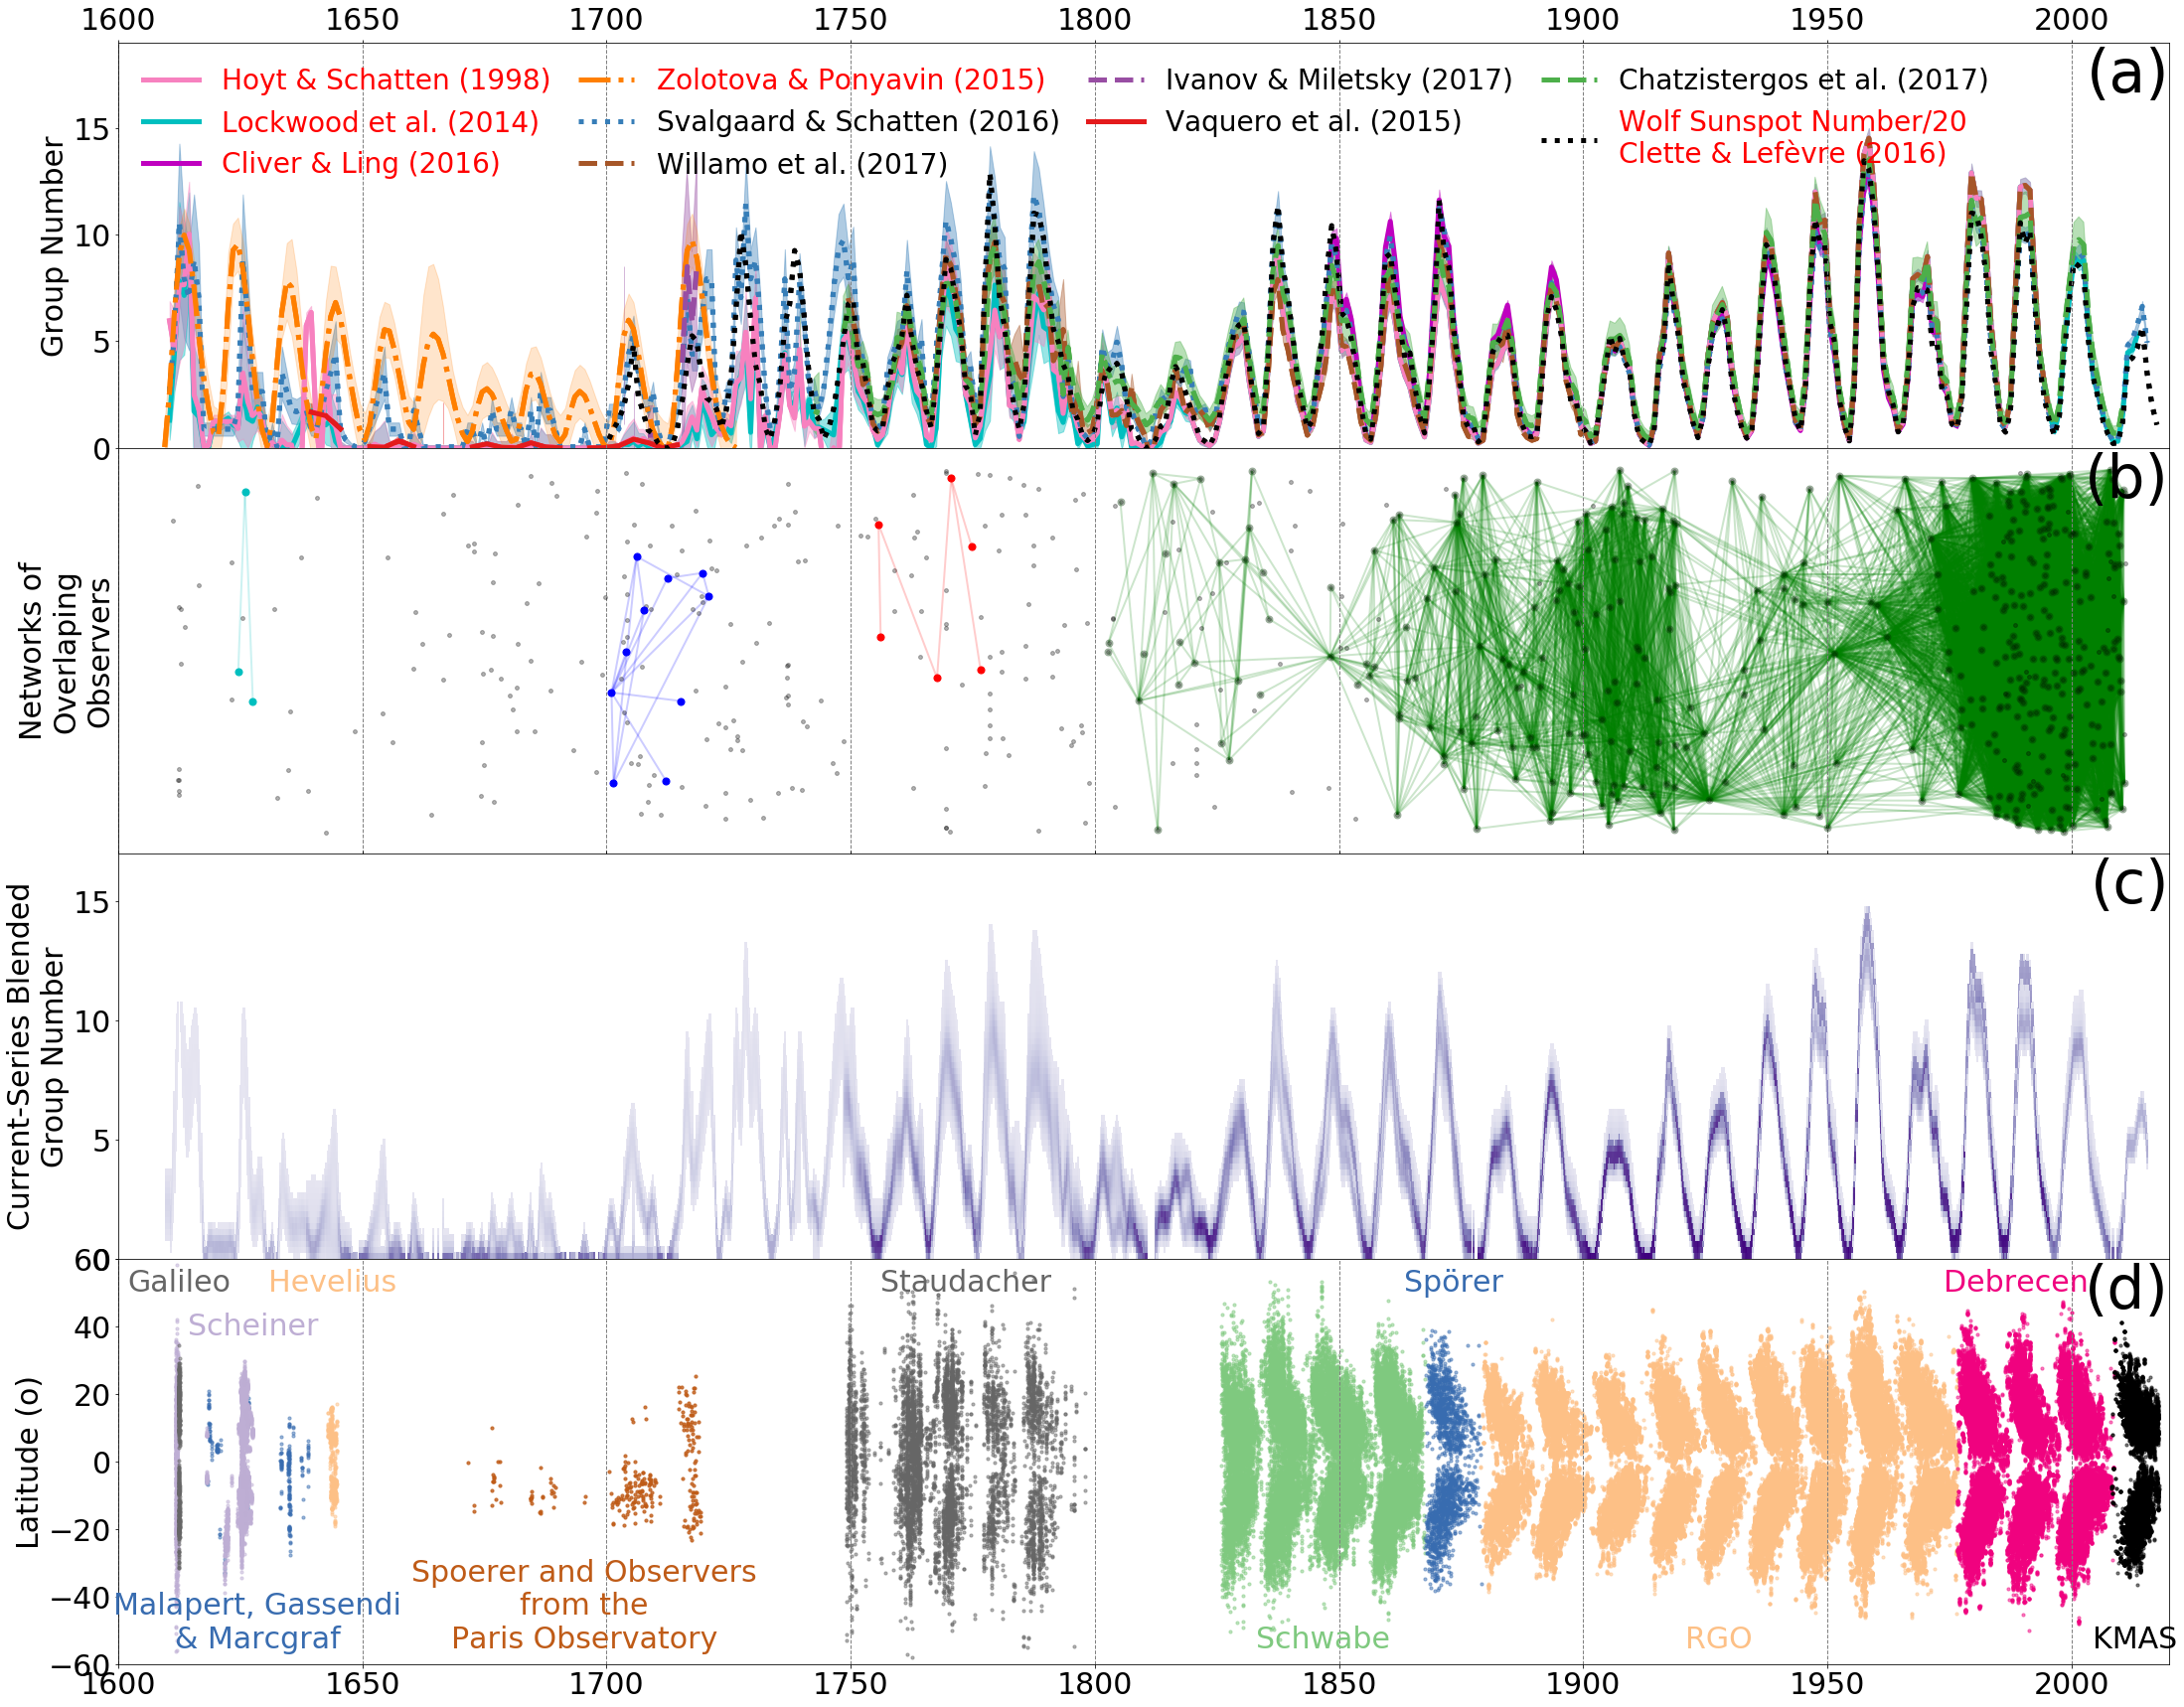

In [30]:
#Creating Graph Network
ObsNtwrk = nx.from_scipy_sparse_matrix(LnkDays,create_using=nx.Graph())

#Clusters existing in the network
Clst = sorted(nx.connected_components(ObsNtwrk), key = len, reverse=True)

#Plotting Graph Network

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 8600   # Horizontal size of each panel
pxy = 1700    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 4      # Number of vertical panels

# Padding
padv  = 200 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 300 #Horizontal padding in pixels at the edge of the figure
padh2 = 150 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppxx   = pxx/fszh
ppxy   = pxy/fszv
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
Y1 = 1600
Y2 = 2020

fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

ax1 = fig.add_axes([1.6*ppadh, ppadv+3*ppxy, ppxx, ppxy])

#Colors
cmap = plt.cm.get_cmap('Set1')

#LineWidth
LW = 5

ax1.plot(HS_Dat['Year'],HS_Dat['G'], zorder=1, color=cmap(7), linewidth=LW)
ax1.plot(LO_Dat['Year'],LO_Dat['G'], zorder=1, color='c',linestyle='-', linewidth=LW)
ax1.plot(CL_Dat['Year'],CL_Dat['G'], zorder=1, color='m',linestyle='-', linewidth=LW)
ax1.plot(NZM_Dat['Date'],NZM_Dat['G'], zorder=1, color=cmap(4),linestyle='-.', linewidth=LW)
ax1.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax1.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax1.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3),linestyle='--', linewidth=LW)
ax1.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax1.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')
ax1.plot(WSN_Dat['Year'],WSN_Dat['G'], zorder=1, color='k',linestyle=':', linewidth=LW)

leg = ax1.legend(('Hoyt & Schatten (1998)', 'Lockwood et al. (2014)', 'Cliver & Ling (2016)', 'Zolotova & Ponyavin (2015)','Svalgaard & Schatten (2016)', 'Willamo et al. (2017)'
            , 'Ivanov & Miletsky (2017)','Vaquero et al. (2015)', 'Chatzistergos et al. (2017)','Wolf Sunspot Number/20\nClette & Lefèvre (2016)'), 
           ncol = 4, loc = 2, fontsize=28, frameon=False, columnspacing=1)

for i in range(0,4):
    t = leg.get_texts()[i]
    t.set_fontproperties(t.get_fontproperties())
    t.set_color('r')
    
t = leg.get_texts()[9]
t.set_fontproperties(t.get_fontproperties())
t.set_color('r')    

alphUn = 0.4

ax1.fill_between(U_Dat['Year'],U_Dat['G']-U_Dat['S'], U_Dat['G']+U_Dat['S'],color=cmap(6), edgecolor='none',alpha=alphUn)
ax1.fill_between(SS_Dat['Year'],SS_Dat['G']-SS_Dat['S'], SS_Dat['G']+SS_Dat['S'],color=cmap(1), edgecolor='none',alpha=alphUn)
ax1.fill_between(LO_Dat['Year'],LO_Dat['G']-LO_Dat['S'], LO_Dat['G']+LO_Dat['S'],color='c', edgecolor='none',alpha=alphUn)
ax1.fill_between(CL_Dat['Year'],CL_Dat['G']-CL_Dat['S'], CL_Dat['G']+CL_Dat['S'],color='m', edgecolor='none',alpha=alphUn)
ax1.fill_between(HS_Dat['Year'],HS_Dat['G']-HS_Dat['S'], HS_Dat['G']+HS_Dat['S'],color=cmap(7), edgecolor='none',alpha=alphUn)
ax1.fill_between(JV_Dat['Year'],JV_Dat['S1'], JV_Dat['S2'],color=cmap(0), edgecolor='none',alpha=alphUn)
ax1.fill_between(Ch_Dat['Year'],Ch_Dat['G']-Ch_Dat['S2'], Ch_Dat['G']+Ch_Dat['S1'],color=cmap(2), edgecolor='none',alpha=alphUn)
ax1.fill_between(IM_Dat['Year'],IM_Dat['G']-IM_Dat['S'], IM_Dat['G']+IM_Dat['S'],color=cmap(3), edgecolor='none',alpha=alphUn)
ax1.fill_between(NZM_Dat['Date'],NZM_Dat['G']-NZM_Dat['S'], NZM_Dat['G']+NZM_Dat['S'],color=cmap(4), edgecolor='none',alpha=0.2)


ax1.plot(HS_Dat['Year'],HS_Dat['G'], zorder=1, color=cmap(7), linewidth=LW)
ax1.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax1.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax1.plot(NZM_Dat['Date'],NZM_Dat['G'], zorder=1, color=cmap(4),linestyle='-.', linewidth=LW)
ax1.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3),linestyle='--', linewidth=LW)
ax1.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax1.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')
ax1.plot(WSN_Dat['Year'],WSN_Dat['G'], zorder=1, color='k',linestyle=':', linewidth=LW)

ax1.annotate('(a)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')


ax1.set_xlim(left=Y1, right=Y2)
ax1.set_ylim(top=19, bottom=0)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_ylabel('Group Number')
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')

ax2 = fig.add_axes([1.6*ppadh, ppadv+2*ppxy, ppxx, ppxy])

#Node Size
NZ =50

#LineWidth
LW = 2

nx.draw_networkx_nodes(ObsNtwrk,pos,node_size=15, node_color='k',alpha=0.3, ax = ax2)

nx.draw_networkx_nodes(ObsNtwrk.subgraph(Clst[0]),pos,node_size=NZ, node_color='k',alpha=0.2, ax = ax2)
nx.draw_networkx_nodes(ObsNtwrk.subgraph(Clst[0]),pos,node_size=NZ,alpha=0.1, node_color='g', ax = ax2)
nx.draw_networkx_edges(ObsNtwrk.subgraph(Clst[0]),pos,alpha=0.2, edge_color='g', ax = ax2, width=LW)

nx.draw_networkx_nodes(ObsNtwrk.subgraph(Clst[1]),pos,node_size=NZ, node_color='b', ax = ax2)
nx.draw_networkx_edges(ObsNtwrk.subgraph(Clst[1]),pos,alpha=0.2, edge_color='b', ax = ax2, width=LW)

nx.draw_networkx_nodes(ObsNtwrk.subgraph(Clst[2]),pos,node_size=NZ, node_color='r', ax = ax2)
nx.draw_networkx_edges(ObsNtwrk.subgraph(Clst[2]),pos,alpha=0.2, edge_color='r', ax = ax2, width=LW)

nx.draw_networkx_nodes(ObsNtwrk.subgraph(Clst[3]),pos,node_size=NZ, node_color='c', ax = ax2)
nx.draw_networkx_edges(ObsNtwrk.subgraph(Clst[3]),pos,alpha=0.2, edge_color='c', ax = ax2, width=LW)


ax2.set_xlim(left=Y1, right=Y2)
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_ylabel('Networks of\nOverlaping\nObservers')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')

ax2.annotate('(b)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')



ax4 = fig.add_axes([1.6*ppadh, ppadv+ppxy, ppxx, ppxy])

cmap = plt.get_cmap('Purples')
pch = ax4.pcolormesh(YrBl, GrpsBl, np.transpose(GrpsBM), alpha =1, cmap=cmap,edgecolors='None',vmin = -0.5, vmax = np.nanmax(GrpsBM))

ax4.set_xlim(left=Y1, right=Y2)
ax4.xaxis.tick_top()
ax4.set_xticklabels([])
ax4.set_ylabel('Current-Series Blended\nGroup Number')

ax4.annotate('(c)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')



ax3 = fig.add_axes([1.6*ppadh, ppadv, ppxx, ppxy])

#Area limit for modern data
ALim = 10

#Marker Size
MZ = 10

#Font size
FZ = 30


cmap = plt.cm.get_cmap('Accent')


ax3.scatter(BflyHvl['Year'],BflyHvl['Lat'],MZ,alpha=0.5,color=cmap(2))
ax3.text( (np.min(BflyHvl['Year'])+np.max(BflyHvl['Year']))/2, 57, 'Hevelius', va='top', ha='center',color=cmap(2), fontsize=FZ)


ax3.scatter(BflyMM1['Year'],BflyMM1['Lat'],MZ,alpha=0.5,color=cmap(4))
ax3.text( (np.min(BflyMM1['Year'])+np.max(BflyMM1['Year']))/2, -57, 'Malapert, Gassendi\n& Marcgraf', va='bottom', ha='center',color=cmap(4), fontsize=FZ)


ax3.scatter(BflySchn['FRACYEAR'],BflySchn['Lat'],MZ,alpha=0.5,color=cmap(1))
ax3.text( (np.min(BflySchn['FRACYEAR'])+np.max(BflySchn['FRACYEAR']))/2+8, 40, 'Scheiner', va='center', ha='center',color=cmap(1), fontsize=FZ)

ax3.scatter(BflyGal['FRACYEAR'],BflyGal['Latitude'],MZ,alpha=0.5,color=cmap(7))
ax3.text( (np.min(BflyGal['FRACYEAR'])+np.max(BflyGal['FRACYEAR']))/2, 57, 'Galileo', va='top', ha='center',color=cmap(7), fontsize=FZ)

ax3.scatter(BflyMM['Year'],BflyMM['Latitude'],MZ,alpha=0.8,color=cmap(6))
ax3.text( (np.min(BflyMM['Year'])+np.max(BflyMM['Year']))/2, -57, 'Spoerer and Observers\nfrom the\nParis Observatory', va='bottom', ha='center',color=cmap(6), fontsize=FZ)

ax3.scatter(BflyStdc['FRACYEAR'],BflyStdc['Lat'],MZ,alpha=0.5,color=cmap(7))
ax3.text( (np.min(BflyStdc['FRACYEAR'])+np.max(BflyStdc['FRACYEAR']))/2, 57, 'Staudacher', va='top', ha='center',color=cmap(7), fontsize=FZ)


ax3.scatter(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1,BflyMod['CORR_A']>=ALim),'FRACYEAR'],BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1,BflyMod['CORR_A']>=ALim),'LATITUDE'],MZ,alpha=0.5,color=cmap(0))
ax3.text( (np.min(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1,BflyMod['CORR_A']>=ALim),'FRACYEAR'])+np.max(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1,BflyMod['CORR_A']>=ALim),'FRACYEAR']))/2, -57, 'Schwabe', va='bottom', ha='center',color=cmap(0), fontsize=FZ)

ax3.scatter(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==2,BflyMod['CORR_A']>=ALim),'FRACYEAR'],BflyMod.loc[np.logical_and(BflyMod['SURVEY']==2,BflyMod['CORR_A']>=ALim),'LATITUDE'],MZ,alpha=0.5,color=cmap(4))
ax3.text( (np.min(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==2,BflyMod['CORR_A']>=ALim),'FRACYEAR'])+np.max(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==2,BflyMod['CORR_A']>=ALim),'FRACYEAR']))/2, 57, 'Spörer', va='top', ha='center',color=cmap(4), fontsize=FZ)

ax3.scatter(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1004,BflyMod['CORR_A']>=ALim),'FRACYEAR'],BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1004,BflyMod['CORR_A']>=ALim),'LATITUDE'],MZ,alpha=0.5,color=cmap(2))
ax3.text( (np.min(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1004,BflyMod['CORR_A']>=ALim),'FRACYEAR'])+np.max(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1004,BflyMod['CORR_A']>=ALim),'FRACYEAR']))/2, -57, 'RGO', va='bottom', ha='center',color=cmap(2), fontsize=FZ)

ax3.scatter(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1003,BflyMod['CORR_A']>=ALim),'FRACYEAR'],BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1003,BflyMod['CORR_A']>=ALim),'LATITUDE'],MZ,alpha=0.5,color=cmap(5))
ax3.text( (np.min(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1003,BflyMod['CORR_A']>=ALim),'FRACYEAR'])+np.max(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1003,BflyMod['CORR_A']>=ALim),'FRACYEAR']))/2-4, 57, 'Debrecen', va='top', ha='center',color=cmap(5), fontsize=FZ)

ax3.scatter(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1002,BflyMod['CORR_A']>=ALim),'FRACYEAR'],BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1002,BflyMod['CORR_A']>=ALim),'LATITUDE'],MZ,alpha=0.5,color='k')
ax3.text( (np.min(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1002,BflyMod['CORR_A']>=ALim),'FRACYEAR'])+np.max(BflyMod.loc[np.logical_and(BflyMod['SURVEY']==1002,BflyMod['CORR_A']>=ALim),'FRACYEAR']))/2, -57, 'KMAS', va='bottom', ha='center', fontsize=FZ)




ax3.annotate('(d)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')

ax3.set_xlim(left=Y1, right=Y2)
ax3.set_ylim(top=60, bottom=-60)
ax3.set_ylabel('Latitude (o)');
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')


fig.savefig('F1_Solar_Cycle_Obs_Data.png',dpi=figDPI)


# Creating Matrix containing all observations in a window of interest

In [13]:
## Maunder Minimum

Y1 = 1634  # First year of the window of interest
Y2 = 1727  # Second year of the window of interest

# Find all observers with at least one day in the window of interest
UnqObs = GN_Dat.loc[np.logical_and(np.logical_and(GN_Dat.YEAR>=Y1, GN_Dat.YEAR<=Y2),GN_Dat.STATION>0), 'STATION'].values
UnqObs = np.unique(UnqObs)

# Finding the ordinal days that contain these observers completely
OD1 = 9999999
OD2 = 0
for Obs in UnqObs:
    OD1 = np.min(np.append(GN_Dat.loc[GN_Dat.STATION == Obs, 'ORDINAL'].values, OD1))
    OD2 = np.max(np.append(GN_Dat.loc[GN_Dat.STATION == Obs, 'ORDINAL'].values, OD2))
    
# Create Matrix for observations
ObsMat = np.zeros([OD2-OD1+1, UnqObs.shape[0]])*np.nan

# Fill it with observations
for i in range(0,UnqObs.shape[0]):
    ObsData = GN_Dat.loc[GN_Dat.STATION == UnqObs[i], ['ORDINAL','GROUPS']].values
    ObsMat[ObsData[:,0].astype(int)-OD1,i] = ObsData[:,1]
    
    
## Modern period

Y12 = 1865  # First year of the window of interest
Y22 = Y12+Y2-Y1  # Second year of the window of interest

# Find all observers with at least one day in the window of interest
UnqObs2 = GN_Dat.loc[np.logical_and(np.logical_and(GN_Dat.YEAR>=Y12, GN_Dat.YEAR<=Y22),GN_Dat.STATION>0), 'STATION'].values
UnqObs2 = np.unique(UnqObs2)

# Finding the ordinal days that contain these observers completely
OD12 = 9999999
OD22 = 0
for Obs in UnqObs2:
    OD12 = np.min(np.append(GN_Dat.loc[GN_Dat.STATION == Obs, 'ORDINAL'].values, OD12))
    OD22 = np.max(np.append(GN_Dat.loc[GN_Dat.STATION == Obs, 'ORDINAL'].values, OD22))
    
# Create Matrix for observations
ObsMat2 = np.zeros([OD22-OD12+1, UnqObs2.shape[0]])*np.nan

# Fill it with observations
for i in range(0,UnqObs2.shape[0]):
    ObsData2 = GN_Dat.loc[GN_Dat.STATION == UnqObs2[i], ['ORDINAL','GROUPS']].values
    ObsMat2[ObsData2[:,0].astype(int)-OD12,i] = ObsData2[:,1]

# Calculate activity mask based on observation matrix and Yearly Coverage

In [14]:
## Maunder Minimum

# Add observations of all observers to identify active days
ADmsk = (np.nansum(ObsMat,axis=1)>0).astype(float) + 1

# Calculate the number of NaNs each day to identify missing days
MDmsk = np.sum(np.isnan(ObsMat),axis=1)==UnqObs.shape[0]

# Fill days with missing observations with NaN
ADmsk[MDmsk] = ADmsk[MDmsk]-1

# Creating fractional year variable

# Ordinal to fractional
def ordinal2fracy(Ord):
    YEAR = datetime.date.fromordinal(Ord).year     
    return YEAR + ( Ord - datetime.date(YEAR,1,1).toordinal() )/(datetime.date(YEAR+1,1,1).toordinal() - datetime.date(YEAR,1,1).toordinal() )

vordinal2fracy=np.vectorize(ordinal2fracy)
fracyr = vordinal2fracy(np.arange(OD1,OD2+1))



## Modern Period

# Add observations of all observers to identify active days
ADmsk2 = (np.nansum(ObsMat2,axis=1)>0).astype(float) + 1

# Calculate the number of NaNs each day to identify missing days
MDmsk2 = np.sum(np.isnan(ObsMat2),axis=1)==UnqObs2.shape[0]

# Fill days with missing observations with NaN
ADmsk2[MDmsk2] = ADmsk2[MDmsk2]-1

# Creating fractional year variable
fracyr2 = vordinal2fracy(np.arange(OD12,OD22+1))

## Unify Butterfly diagram observations

In [15]:
# Modern data
BflyAll = BflyMod.copy()
BflyAll.loc[BflyAll['CORR_A']<ALim,'LATITUDE'] = np.NaN
BflyAll = BflyAll.loc[np.isfinite(BflyAll['CORR_A']),('FRACYEAR','ORDINAL','LATITUDE')].values

# Hevelius
tmp = BflyHvl.loc[:,('Year','Lat')]
tmp['ORDINAL'] = tmp.apply(lambda x: np.round(datetime.date(np.floor(x['Year']).astype(int),1,1).toordinal()
                           + (x['Year']-np.floor(x['Year']))*(datetime.date(np.floor(x['Year']).astype(int)+1,1,1).toordinal()
                                                             -datetime.date(np.floor(x['Year']).astype(int),1,1).toordinal())).astype(int)
                                  ,axis=1)
tmp = tmp.loc[:,('Year','ORDINAL','Lat')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Galileo
tmp = BflyGal.loc[:,('FRACYEAR','ORDINAL','Latitude')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Scheiner
tmp = BflySchn.loc[:,('FRACYEAR','ORDINAL','Lat')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Harriot
tmp = BflyHrt.loc[:,('FRACYEAR','ORDINAL','Lat')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Staudacher
tmp = BflyStdc.loc[:,('FRACYEAR','ORDINAL','Lat')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Sporer and Ribes 
tmp = BflyMM.loc[:,('Year','Latitude')]
tmp['ORDINAL'] = tmp.apply(lambda x: np.round(datetime.date(np.floor(x['Year']).astype(int),1,1).toordinal()
                           + (x['Year']-np.floor(x['Year']))*(datetime.date(np.floor(x['Year']).astype(int)+1,1,1).toordinal()
                                                             -datetime.date(np.floor(x['Year']).astype(int),1,1).toordinal())).astype(int)
                                  ,axis=1)
tmp = tmp.loc[:,('Year','ORDINAL','Latitude')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Malapert, and so on 
tmp = BflyMM1.loc[:,('Year','Lat')]


tmp['ORDINAL'] = tmp.apply(lambda x: np.round(datetime.date(np.floor(x['Year']).astype(int),1,1).toordinal()
                           + (x['Year']-np.floor(x['Year']))*(datetime.date(np.floor(x['Year']).astype(int)+1,1,1).toordinal()
                                                             -datetime.date(np.floor(x['Year']).astype(int),1,1).toordinal())).astype(int)
                                  ,axis=1)
tmp = tmp.loc[:,('Year','ORDINAL','Lat')].values
BflyAll = np.append(BflyAll,tmp,axis=0)

# Create pandas dataframe
BflyAll = pd.DataFrame(BflyAll, columns=['FRACYEAR','ORDINAL','LATITUDE'])
BflyAll['ORDINAL'] = BflyAll['ORDINAL'].astype(int)



## Calculating coverage of sunspot group observations

In [16]:
# Define years to calculate butterfly diagram coverage
Y1 = 1600
Y2 = 1900

# Number of years in coverage window
YrCum = 2

# Removing days wihout observers
CvrObs = GN_Dat['ORDINAL'].copy()
CrvObs = CvrObs[GN_Dat['STATION']>0]

# Identifying each day with an observation
CrvObs = np.unique(CrvObs)

# Calculate the corresponding fractional year
CrvObsFy = vordinal2fracy(CrvObs)

# Set up repository variables
CrvObsYr = np.arange(Y1,Y2+1,YrCum)
CrvObsCv = CrvObsYr.copy().astype(float)*0

for i in np.arange(0,CrvObsYr.shape[0]):
    # Calculate number of days in year
    NdaysYr = datetime.date(CrvObsYr[i]+YrCum,1,1).toordinal()-datetime.date(CrvObsYr[i],1,1).toordinal()
    
    # Find number of observations in first year of the bin
    NdaysOb = np.sum(np.floor(CrvObsFy)==CrvObsYr[i])
    
    # Add other years to the bin
    for j in np.arange(1,YrCum):
        NdaysOb = NdaysOb + np.sum(np.floor(CrvObsFy)==CrvObsYr[i]+j)
    
    # Calculate coverage
    CrvObsCv[i] = NdaysOb/NdaysYr

## Calculate observational coverage based on butterfly diagram

In [17]:
Y1 = 1600
Y2 = 1980

# Calculate a unique list of days represented in the butterfly diagram
ObsDsBfly = np.unique(BflyAll['ORDINAL'])
    
# Calculate the corresponding fractional year
BfObsFy = vordinal2fracy(ObsDsBfly)

# Set up repository variables
BfObsYr = np.arange(Y1,Y2+1,YrCum)
BfObsCv = BfObsYr.copy().astype(float)*0

for i in np.arange(0,BfObsYr.shape[0]):
    # Calculate number of days in year
    NdaysYr = datetime.date(BfObsYr[i]+YrCum,1,1).toordinal()-datetime.date(BfObsYr[i],1,1).toordinal()
    
    # Find number of observations in first year of the bin
    NdaysOb = np.sum(np.floor(BfObsFy)==BfObsYr[i])
    
    # Add other years to the bin
    for j in np.arange(1,YrCum):
        NdaysOb = NdaysOb + np.sum(np.floor(BfObsFy)==BfObsYr[i]+j)
    
    # Calculate coverage
    BfObsCv[i] = NdaysOb/NdaysYr    

## Plot activity mask by reshaping into months

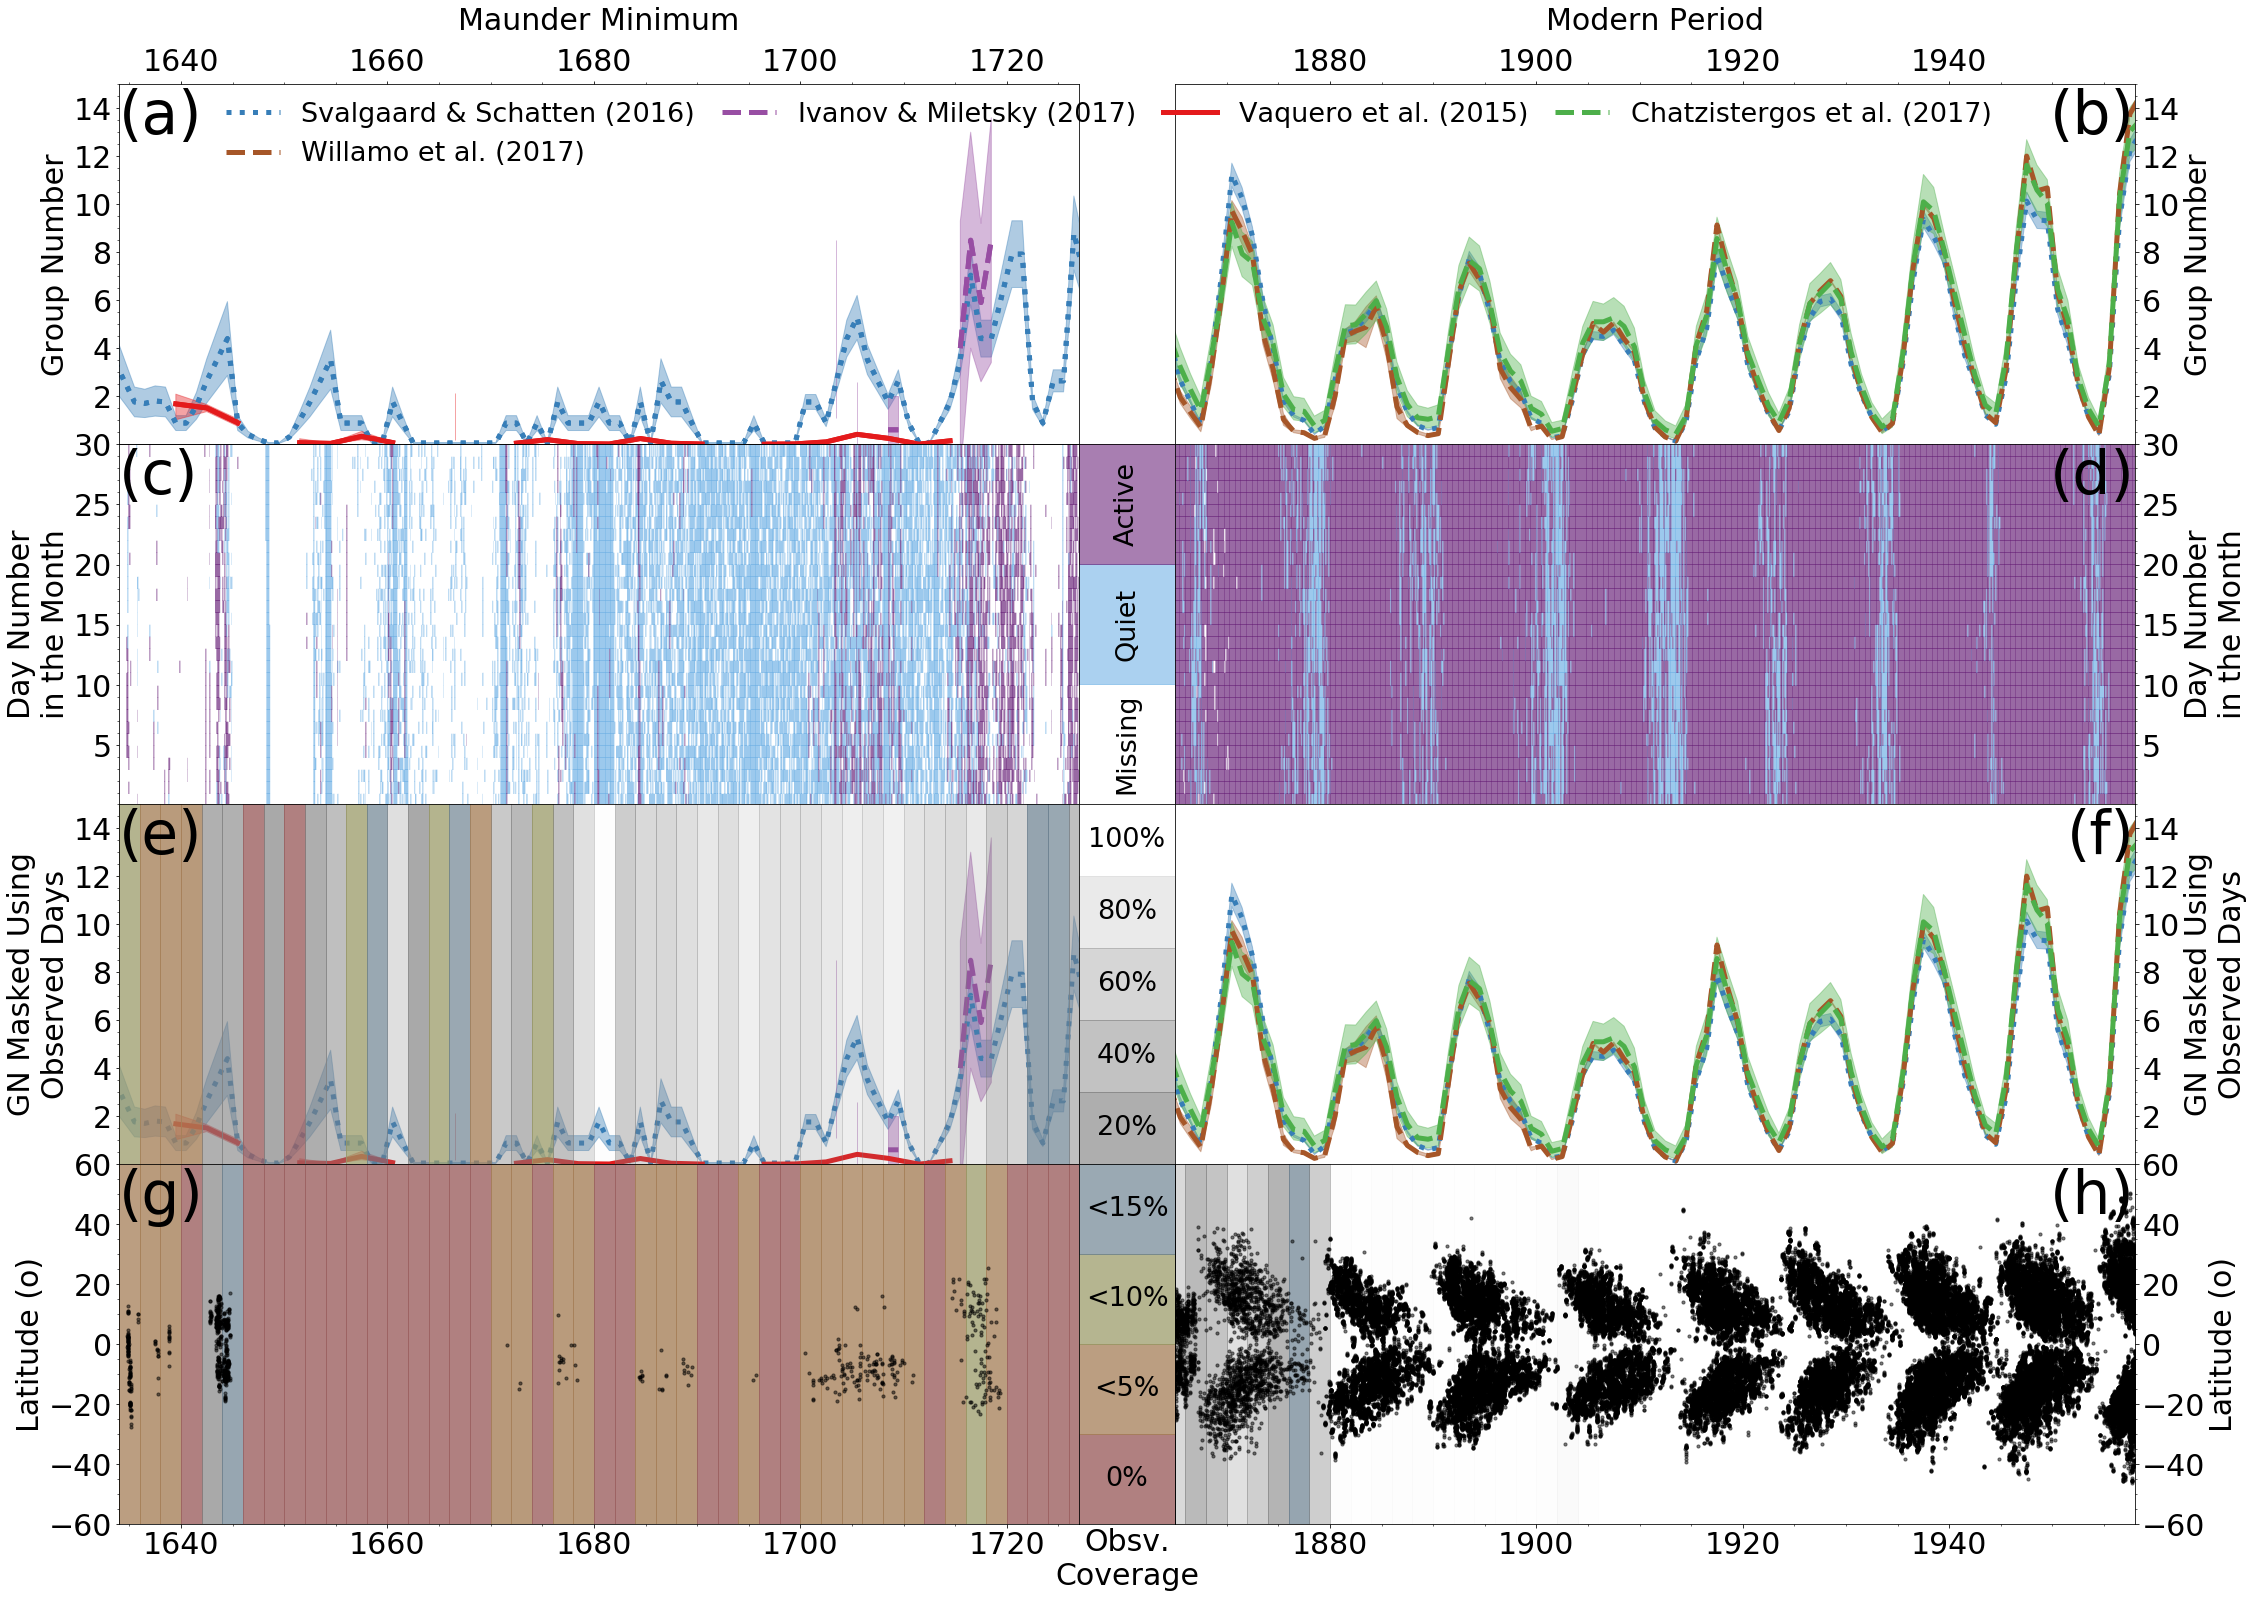

In [18]:
Y1 = 1634  # First year of the window of interest
Y2 = 1727  # Second year of the window of interest

# Number of days per "month"
MoLngt = 30

## Maunder Minimum

ADmskPlt = ADmsk[0:np.int(ADmsk.shape[0]/MoLngt)*MoLngt].copy()
fracyrPlt = fracyr[0:np.int(ADmsk.shape[0]/MoLngt)*MoLngt].copy()

# Reshaping
ADmskPlt = ADmskPlt.reshape((-1,MoLngt))
fracyrPlt = fracyrPlt.reshape((-1,MoLngt))
fracyrPlt = np.mean(fracyrPlt,axis=1)


# Observational coverage variable
ObsYr = np.arange(np.min(np.floor(fracyr)),np.max(np.floor(fracyr)))
ObsCv = ObsYr.copy()*0
                  
for i in np.arange(0,ObsCv.shape[0]):    
    ObsCv[i] = np.sum(ADmskPlt[np.floor(fracyrPlt)==ObsYr[i],:]>0)/( np.sum(np.floor(fracyrPlt)==ObsYr[i])*MoLngt )
  
xMesh = np.insert(fracyrPlt,0,fracyrPlt[0])
yMesh = np.arange(0,MoLngt+1)
    
## Modern Period

ADmskPlt2 = ADmsk2[0:np.int(ADmsk2.shape[0]/MoLngt)*MoLngt].copy()
fracyrPlt2 = fracyr2[0:np.int(ADmsk2.shape[0]/MoLngt)*MoLngt].copy()

# Reshaping
ADmskPlt2 = ADmskPlt2.reshape((-1,MoLngt))
fracyrPlt2 = fracyrPlt2.reshape((-1,MoLngt))
fracyrPlt2 = np.mean(fracyrPlt2,axis=1)


# Observational coverage variable
ObsYr2 = np.arange(np.min(np.floor(fracyr2)),np.max(np.floor(fracyr2)))
ObsCv2 = ObsYr2.copy()*0
                  
for i in np.arange(0,ObsCv.shape[0]):    
    ObsCv2[i] = np.sum(ADmskPlt2[np.floor(fracyrPlt2)==ObsYr2[i],:]>0)/( np.sum(np.floor(fracyrPlt2)==ObsYr2[i])*MoLngt )    
    
xMesh2 = np.insert(fracyrPlt2,0,fracyrPlt2[0])


plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1500    # Vertical size of each panel

nph = 2      # Number of horizontal panels
npv = 4      # Number of vertical panels

# Padding
padv  = 350 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 520 #Horizontal padding in pixels at the edge of the figure
padh2 = 400 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppxx   = pxx/fszh
ppxy   = pxy/fszv
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

#Colormap
colors = [(1, 1, 1), Clr[4], Clr[2]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax1 = fig.add_axes([ppadh, ppadv+2*ppxy, ppxx, ppxy])
pch = ax1.pcolormesh(xMesh, yMesh, np.transpose(ADmskPlt), cmap = cmap, alpha = 0.45, linewidth = 2)
ax1.set_ylim(bottom = 0.1, top = MoLngt)
ax1.set_xlim(left=Y1, right=Y2)

# Axes properties
ax1.set_ylabel('Day Number\nin the Month')
ax1.minorticks_on()

ax1.annotate('(c)',xy=(0, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='left')


# Add Colorbar
axcb1  = fig.add_axes([ppadh+ppxx, ppadv+2*ppxy, ppadh2, ppxy])
axcb1.fill([0,0,1,1], [0, 1, 1, 0], color=(1, 1, 1), alpha = 0.6, edgecolor = 'none')
axcb1.fill([0,0,1,1], [1, 2, 2, 1], color=Clr[4], alpha = 0.6, edgecolor = 'none')
axcb1.fill([0,0,1,1], [2, 3, 3, 2], color=Clr[2], alpha = 0.6, edgecolor = 'none')

axcb1.annotate('Missing', xy = (0.5, 0.5), horizontalalignment='center', verticalalignment='center', rotation='vertical', 
           fontsize=27,zorder=3, )
axcb1.annotate('Quiet', xy = (0.5, 1.5), horizontalalignment='center', verticalalignment='center', rotation='vertical', 
           fontsize=27,zorder=3, )
axcb1.annotate('Active', xy = (0.5, 2.5), horizontalalignment='center', verticalalignment='center', rotation='vertical', 
           fontsize=27,zorder=3, )

axcb1.set_ylim(bottom = 0, top = 3)
axcb1.set_xlim(left=0, right=1)    

axcb1.set_xticks([])
axcb1.set_yticks([])

y2 = 15

ax2 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])

#Colors
cmap = plt.cm.get_cmap('Set1')

#LineWidth
LW = 5

ax2.fill_between(U_Dat['Year'],U_Dat['G']-U_Dat['S'], U_Dat['G']+U_Dat['S'],color=cmap(6), edgecolor='none',alpha=alphUn)
ax2.fill_between(SS_Dat['Year'],SS_Dat['G']-SS_Dat['S'], SS_Dat['G']+SS_Dat['S'],color=cmap(1), edgecolor='none',alpha=alphUn)
ax2.fill_between(JV_Dat['Year'],JV_Dat['S1'], JV_Dat['S2'],color=cmap(0), edgecolor='none',alpha=alphUn)
ax2.fill_between(Ch_Dat['Year'],Ch_Dat['G']-Ch_Dat['S2'], Ch_Dat['G']+Ch_Dat['S1'],color=cmap(2), edgecolor='none',alpha=alphUn)
ax2.fill_between(IM_Dat['Year'],IM_Dat['G']-IM_Dat['S'], IM_Dat['G']+IM_Dat['S'],color=cmap(3), edgecolor='none',alpha=alphUn)


ax2.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax2.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax2.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax2.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')
ax2.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3), linewidth=LW,linestyle='--')


#Colormap for transparency mask
colorsMsk = [(0.65,0.5,0.35), (0.60,0.60,0.4), (0.42,0.5,0.56), (0.5,0.5,0.5)]
color0 = (0.61,0.38,0.38)

MaskMaxAl = 0.8

# Plot transparency mask
for i in np.arange(0,CrvObsYr.shape[0]):
    if CrvObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(CrvObsCv[i]/0.05)])))]
    ax2.fill([CrvObsYr[i], CrvObsYr[i], CrvObsYr[i]+YrCum, CrvObsYr[i]+YrCum], [0, 17, 17, 0], color=clr, alpha = (1-CrvObsCv[i])*MaskMaxAl, zorder=2, edgecolor = 'none')

    
ax2.set_ylim(bottom = 0, top = y2)
ax2.set_xlim(left=Y1, right=Y2)

# Axes properties
ax2.set_ylabel('GN Masked Using\nObserved Days')
ax2.minorticks_on()

ax2.annotate('(e)',xy=(0, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='left')
ax2.set_yticks(np.arange(2,16,2))

# Add Colorbar
axcb2  = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppadh2, ppxy])
for i in range(1,6):
    axcb2.fill([0,0,1,1], [i, i+1, i+1, i], color=(0.5,0.5,0.5), alpha = (1-i/5)*MaskMaxAl, edgecolor = 'none')
    axcb2.annotate(str(20*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb2.set_ylim(bottom = 1, top = 6)
axcb2.set_xlim(left=0, right=1)    

axcb2.set_xticks([])
axcb2.set_yticks([])



## Modern Period

ax6 = fig.add_axes([ppadh+ppxx+ppadh2, ppadv+3*ppxy, ppxx, ppxy])

#Colors
cmap = plt.cm.get_cmap('Set1')

#LineWidth
LW = 5

ax6.fill_between(U_Dat['Year'],U_Dat['G']-U_Dat['S'], U_Dat['G']+U_Dat['S'],color=cmap(6), edgecolor='none',alpha=alphUn)
ax6.fill_between(SS_Dat['Year'],SS_Dat['G']-SS_Dat['S'], SS_Dat['G']+SS_Dat['S'],color=cmap(1), edgecolor='none',alpha=alphUn)
ax6.fill_between(JV_Dat['Year'],JV_Dat['S1'], JV_Dat['S2'],color=cmap(0), edgecolor='none',alpha=alphUn)
ax6.fill_between(Ch_Dat['Year'],Ch_Dat['G']-Ch_Dat['S2'], Ch_Dat['G']+Ch_Dat['S1'],color=cmap(2), edgecolor='none',alpha=alphUn)


ax6.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax6.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax6.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax6.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')

    
ax6.set_ylim(bottom = 0, top = y2)
ax6.set_xlim(left=Y12, right=Y22)
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position('right')
ax6.xaxis.tick_top()
ax6.xaxis.set_label_position('top')


# Axes properties
ax6.set_ylabel('Group Number')
ax6.minorticks_on()
ax6.set_yticks(np.arange(2,16,2))

ax6.text(0.5, 1.15,'Modern Period', horizontalalignment='center',
         fontsize=30,
         transform = ax6.transAxes);

ax6.annotate('(b)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')

ax3 = fig.add_axes([ppadh, ppadv+3*ppxy, ppxx, ppxy])

#Colors
cmap = plt.cm.get_cmap('Set1')

#LineWidth
LW = 5

ax3.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax3.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax3.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3), linewidth=LW,linestyle='--')
ax3.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax3.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')

ax3.legend(('Svalgaard & Schatten (2016)', 'Willamo et al. (2017)','Ivanov & Miletsky (2017)','Vaquero et al. (2015)', 'Chatzistergos et al. (2017)'), 
           ncol = 4, loc = (0.1,0.74), fontsize=27, frameon=False, columnspacing=1)

alphUn = 0.4

ax3.fill_between(U_Dat['Year'],U_Dat['G']-U_Dat['S'], U_Dat['G']+U_Dat['S'],color=cmap(6), edgecolor='none',alpha=alphUn)
ax3.fill_between(SS_Dat['Year'],SS_Dat['G']-SS_Dat['S'], SS_Dat['G']+SS_Dat['S'],color=cmap(1), edgecolor='none',alpha=alphUn)
ax3.fill_between(IM_Dat['Year'],IM_Dat['G']-IM_Dat['S'], IM_Dat['G']+IM_Dat['S'],color=cmap(3), edgecolor='none',alpha=alphUn)
ax3.fill_between(JV_Dat['Year'],JV_Dat['S1'], JV_Dat['S2'],color=cmap(0), edgecolor='none',alpha=alphUn)
ax3.fill_between(Ch_Dat['Year'],Ch_Dat['G']-Ch_Dat['S2'], Ch_Dat['G']+Ch_Dat['S1'],color=cmap(2), edgecolor='none',alpha=alphUn)


ax3.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax3.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax3.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3), linewidth=LW,linestyle='--')
ax3.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax3.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')

    
ax3.set_ylim(bottom = 0, top = y2)
ax3.set_xlim(left=Y1, right=Y2)
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')

# Axes properties
ax3.set_ylabel('Group Number')
ax3.minorticks_on()
ax3.set_yticks(np.arange(2,16,2))

ax3.text(0.5, 1.15,'Maunder Minimum', horizontalalignment='center',
         fontsize=30,
         transform = ax3.transAxes);

ax3.annotate('(a)',xy=(0, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='left')


#Colormap
colors = [(1, 1, 1), Clr[4], Clr[2]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax4 = fig.add_axes([ppadh+ppxx+ppadh2, ppadv+2*ppxy, ppxx, ppxy])
ax4.pcolormesh(xMesh2, yMesh, np.transpose(ADmskPlt2), cmap = cmap, alpha = 0.45, linewidth = 2)
ax4.set_ylim(bottom = 0.1, top = MoLngt)
ax4.set_xlim(left=Y12, right=Y22)

# Axes properties
ax4.set_ylabel('Day Number\nin the Month')
ax4.minorticks_on()
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')

ax4.annotate('(d)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')


ax5 = fig.add_axes([ppadh+ppxx+ppadh2, ppadv+ppxy, ppxx, ppxy])

#Colors
cmap = plt.cm.get_cmap('Set1')

#LineWidth
LW = 5

ax5.fill_between(U_Dat['Year'],U_Dat['G']-U_Dat['S'], U_Dat['G']+U_Dat['S'],color=cmap(6), edgecolor='none',alpha=alphUn)
ax5.fill_between(SS_Dat['Year'],SS_Dat['G']-SS_Dat['S'], SS_Dat['G']+SS_Dat['S'],color=cmap(1), edgecolor='none',alpha=alphUn)
ax5.fill_between(JV_Dat['Year'],JV_Dat['S1'], JV_Dat['S2'],color=cmap(0), edgecolor='none',alpha=alphUn)
ax5.fill_between(Ch_Dat['Year'],Ch_Dat['G']-Ch_Dat['S2'], Ch_Dat['G']+Ch_Dat['S1'],color=cmap(2), edgecolor='none',alpha=alphUn)

ax5.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax5.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax5.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)
ax5.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')

 

ax5.set_ylim(bottom = 0, top = y2)
ax5.set_xlim(left=Y12, right=Y22)

# Axes properties
ax5.set_ylabel('GN Masked Using\nObserved Days')
ax5.minorticks_on()
ax5.set_yticks(np.arange(2,16,2))
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position('right')

ax5.annotate('(f)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')

ax7 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

# Plot transparency mask
for i in np.arange(0,BfObsYr.shape[0]):
    if BfObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(BfObsCv[i]/0.05)])))]
    ax7.fill([BfObsYr[i], BfObsYr[i], BfObsYr[i]+YrCum, BfObsYr[i]+YrCum], [-60, 60, 60, -60], color=clr, alpha = (1-BfObsCv[i])*MaskMaxAl, zorder=0, edgecolor = 'none')


ax7.scatter(BflyAll['FRACYEAR'],BflyAll['LATITUDE'],MZ,alpha=0.5,color='k')

ax7.set_ylim(top=60, bottom=-60)
ax7.set_xlim(left=Y1, right=Y2)

# Axes properties
ax7.set_ylabel('Latitude (o)');
ax7.minorticks_on()

ax7.annotate('(g)',xy=(0, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='left')

ax8 = fig.add_axes([ppadh+ppxx+ppadh2, ppadv, ppxx, ppxy])


# Plot transparency mask
for i in np.arange(0,BfObsYr.shape[0]):
    if BfObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(BfObsCv[i]/0.05)])))]
    ax8.fill([BfObsYr[i], BfObsYr[i], BfObsYr[i]+YrCum, BfObsYr[i]+YrCum], [-60, 60, 60, -60], color=clr, alpha = (1-BfObsCv[i])*MaskMaxAl, zorder=0, edgecolor = 'none')


ax8.scatter(BflyAll['FRACYEAR'],BflyAll['LATITUDE'],MZ,alpha=0.5,color='k')



ax8.set_ylim(top=60, bottom=-60)
ax8.set_xlim(left=Y12, right=Y22)

# Axes properties
ax8.set_ylabel('Latitude (o)');
# ax8.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax8.minorticks_on()
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position('right')

ax8.annotate('(h)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')


# Add Colorbar
axcb3  = fig.add_axes([ppadh+ppxx, ppadv, ppadh2, ppxy])

axcb3.fill([0,0,1,1], [0, 1, 1, 0], color=color0, alpha = MaskMaxAl, edgecolor = 'none')
axcb3.annotate('0%', xy = (0.5, 0.5), horizontalalignment='center', verticalalignment='center',
               fontsize=27,zorder=3, )
for i in range(1,4):
    clr = colorsMsk[i-1]
    axcb3.fill([0,0,1,1], [i, i+1, i+1, i], color=clr, alpha = (1-i/20)*MaskMaxAl, edgecolor = 'none')
    axcb3.annotate('<'+str(5*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb3.set_ylim(bottom = 0, top = 4)
axcb3.set_xlim(left=0, right=1)    

axcb3.set_xticks([])
axcb3.set_yticks([])
axcb3.set_xlabel('Obsv.\nCoverage')



fig.savefig('F2_MM_vs_Modern.png',dpi=figDPI)


In [19]:
colors = [(0.65,0.5,0.35), (0.60,0.60,0.4), (0.42,0.5,0.56), (0.5,0.5,0.5)]
color0 = (0.61,0.38,0.38)
cmapMsk = clrs.LinearSegmentedColormap.from_list('cmapMsk', colors, N=5)
norm = clrs.Normalize(vmin=0, vmax=0.15, clip=True)

colors[(int(np.min([3,np.floor(0.2/0.05)])))]

(0.5, 0.5, 0.5)

## Long-term historic data plot

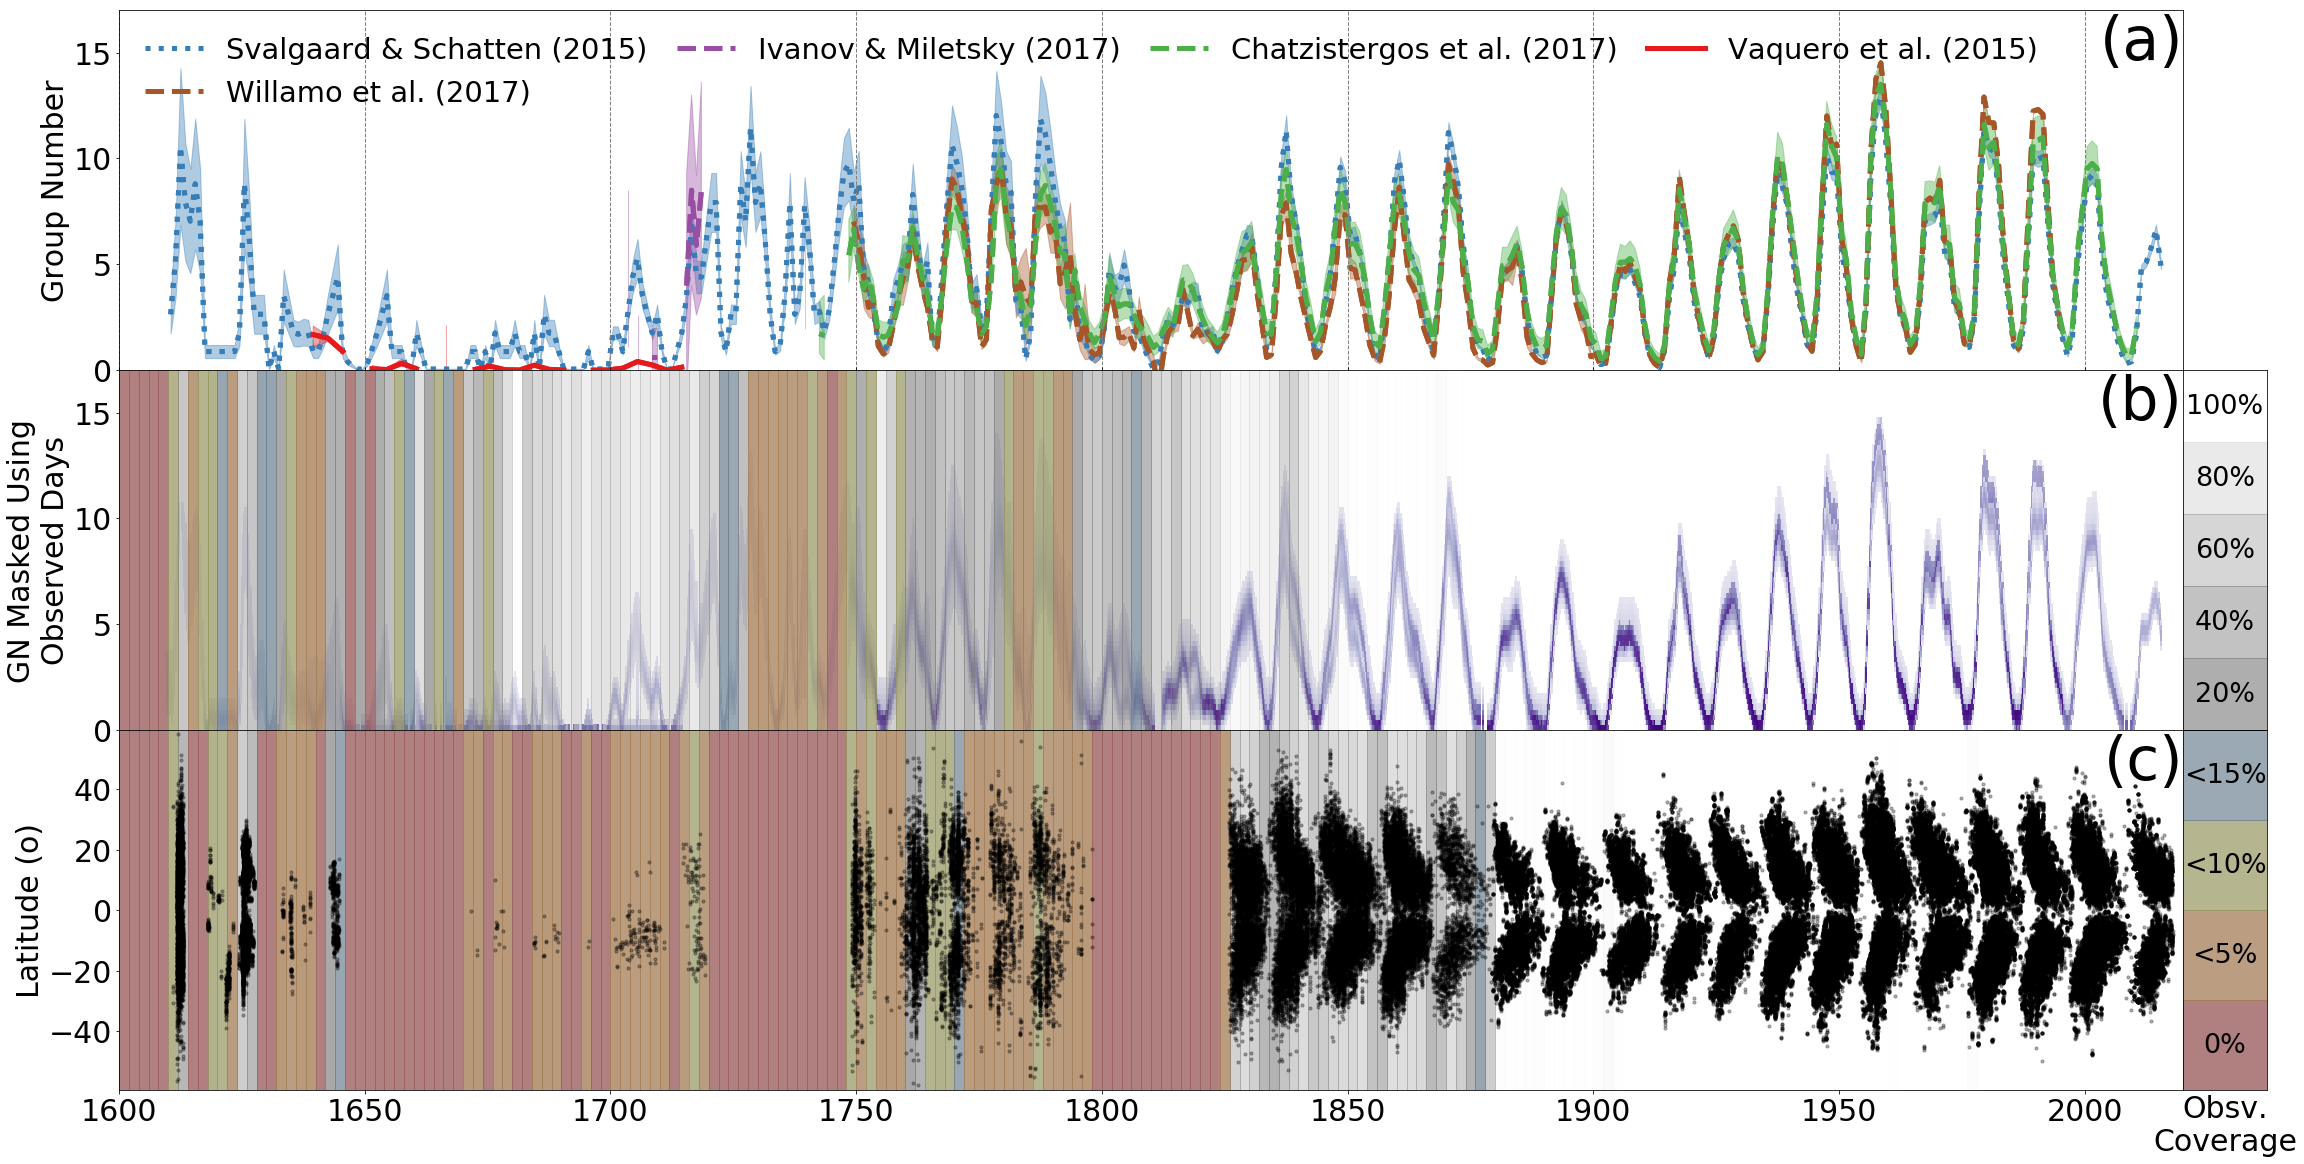

In [20]:
#Plotting Graph Network

# Size definitions
dpi = 300
pxx = 8600   # Horizontal size of each panel
pxy = 1500    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3     # Number of vertical panels

# Padding
padv  = 300 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 600 #Horizontal padding in pixels at the edge of the figure
padh2 = 350 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppxx   = pxx/fszh
ppxy   = pxy/fszv
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
Y1 = 1600
Y2 = 2020

fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


plt.rc('font', **font)


ax1 = fig.add_axes([ppadh, ppadv+2*ppxy, ppxx, ppxy])

#Colors
cmap = plt.cm.get_cmap('Set1')

#LineWidth
LW = 5

ax1.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax1.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax1.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3), linewidth=LW,linestyle='--')
ax1.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')
ax1.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)

ax1.legend(('Svalgaard & Schatten (2015)', 'Willamo et al. (2017)'
            ,'Ivanov & Miletsky (2017)','Chatzistergos et al. (2017)','Vaquero et al. (2015)'), 
           ncol = 4, loc = 2, fontsize=29, frameon=False, columnspacing=1)

ax1.fill_between(U_Dat['Year'],U_Dat['G']-U_Dat['S'], U_Dat['G']+U_Dat['S'],color=cmap(6), edgecolor='none',alpha=alphUn)
ax1.fill_between(SS_Dat['Year'],SS_Dat['G']-SS_Dat['S'], SS_Dat['G']+SS_Dat['S'],color=cmap(1), edgecolor='none',alpha=alphUn)
ax1.fill_between(JV_Dat['Year'],JV_Dat['S1'], JV_Dat['S2'],color=cmap(0), edgecolor='none',alpha=alphUn)
ax1.fill_between(Ch_Dat['Year'],Ch_Dat['G']-Ch_Dat['S2'], Ch_Dat['G']+Ch_Dat['S1'],color=cmap(2), edgecolor='none',alpha=alphUn)
ax1.fill_between(IM_Dat['Year'],IM_Dat['G']-IM_Dat['S'], IM_Dat['G']+IM_Dat['S'],color=cmap(3), edgecolor='none',alpha=alphUn)


ax1.plot(SS_Dat['Year'],SS_Dat['G'], zorder=1, color=cmap(1),linestyle=':',linewidth=LW)
ax1.plot(U_Dat['Year'],U_Dat['G'], zorder=1, color=cmap(6),linestyle='--', linewidth=LW)
ax1.plot(IM_Dat['Year'],IM_Dat['G'], zorder=1, color=cmap(3), linewidth=LW,linestyle='--')
ax1.plot(Ch_Dat['Year'],Ch_Dat['G'], zorder=1, color=cmap(2), linewidth=LW,linestyle='--')
ax1.plot(JV_Dat['Year'],JV_Dat['G'], zorder=1, color=cmap(0), linewidth=LW)

ax1.annotate('(a)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')


ax1.set_xlim(left=Y1, right=Y2)
ax1.set_ylim(top=17, bottom=0)
ax1.set_xticklabels([])
ax1.xaxis.set_label_position('top')
ax1.set_ylabel('Group Number')
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')



ax3 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])

cmap = plt.get_cmap('Purples')
pch = ax3.pcolormesh(YrBl, GrpsBl, np.transpose(GrpsBM), alpha =1, cmap=cmap,edgecolors='None',vmin = -0.5, vmax = np.nanmax(GrpsBM))

# Plot transparency mask
for i in np.arange(0,CrvObsYr.shape[0]):
    if CrvObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(CrvObsCv[i]/0.05)])))]
    ax3.fill([CrvObsYr[i], CrvObsYr[i], CrvObsYr[i]+YrCum, CrvObsYr[i]+YrCum], [0, 17, 17, 0], color=clr, alpha = (1-CrvObsCv[i])*MaskMaxAl, zorder=2, edgecolor = 'none')

ax3.set_xlim(left=Y1, right=Y2)
ax3.xaxis.tick_top()
ax3.set_xticklabels([])
ax3.set_ylabel('GN Masked Using\nObserved Days')

ax3.annotate('(b)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')


ax2 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

# Plot transparency mask
for i in np.arange(0,BfObsYr.shape[0]):
    if BfObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(BfObsCv[i]/0.05)])))]
    ax2.fill([BfObsYr[i], BfObsYr[i], BfObsYr[i]+YrCum, BfObsYr[i]+YrCum], [-60, 60, 60, -60], color=clr, alpha = (1-BfObsCv[i])*MaskMaxAl, zorder=0, edgecolor = 'none')
        
ax2.scatter(BflyAll['FRACYEAR'],BflyAll['LATITUDE'],MZ,alpha=0.3,color='k')

ax2.annotate('(c)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')


ax2.set_xlim(left=Y1, right=Y2)
ax2.set_ylim(top=59.5, bottom=-59.5)
ax2.set_ylabel('Latitude (o)');
# ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')

# Add Colorbar
axcb3  = fig.add_axes([ppadh+ppxx, ppadv, ppadh2, ppxy])

axcb3.fill([0,0,1,1], [0, 1, 1, 0], color=color0, alpha = MaskMaxAl, edgecolor = 'none')
axcb3.annotate('0%', xy = (0.5, 0.5), horizontalalignment='center', verticalalignment='center',
               fontsize=27,zorder=3, )
for i in range(1,4):
    clr = colorsMsk[i-1]
    axcb3.fill([0,0,1,1], [i, i+1, i+1, i], color=clr, alpha = (1-i/20)*MaskMaxAl, edgecolor = 'none')
    axcb3.annotate('<'+str(5*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb3.set_ylim(bottom = 0, top = 4)
axcb3.set_xlim(left=0, right=1)    

axcb3.set_xticks([])
axcb3.set_yticks([])
axcb3.set_xlabel('Obsv.\nCoverage')


# Add Colorbar
axcb2  = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppadh2, ppxy])
for i in range(1,6):
    axcb2.fill([0,0,1,1], [i, i+1, i+1, i], color=(0.5,0.5,0.5), alpha = (1-i/5)*MaskMaxAl, edgecolor = 'none')
    axcb2.annotate(str(20*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb2.set_ylim(bottom = 1, top = 6)
axcb2.set_xlim(left=0, right=1)    

axcb2.set_xticks([])
axcb2.set_yticks([])

fig.savefig('F3_Bfly_GN_Coverage.png',dpi=figDPI)

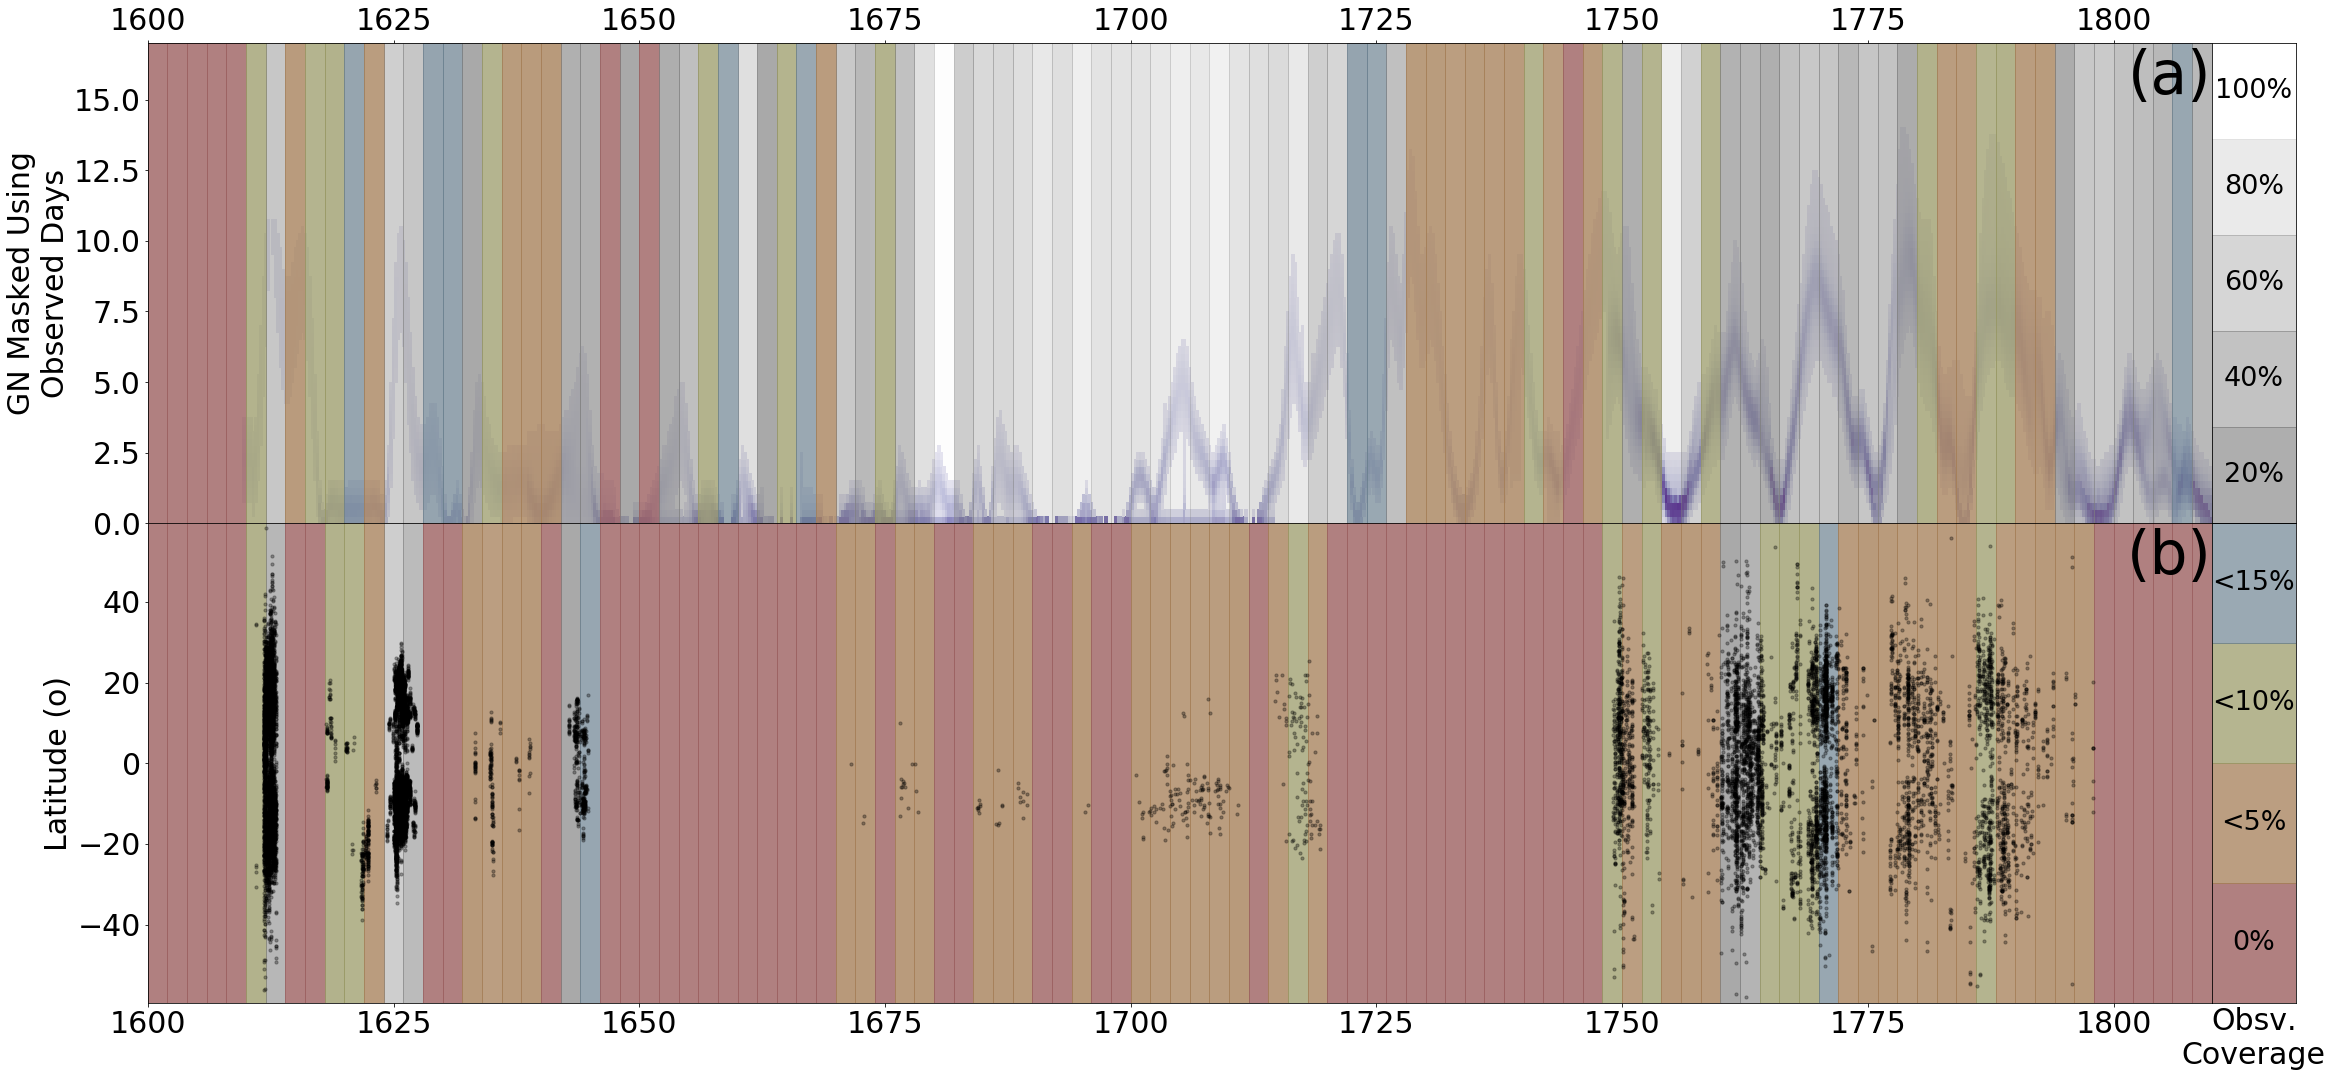

In [21]:

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 8600   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 2      # Number of vertical panels

# Padding
padv  = 300 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 600 #Horizontal padding in pixels at the edge of the figure
padh2 = 350 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppxx   = pxx/fszh
ppxy   = pxy/fszv
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
Y1 = 1600
Y2 = 1810

fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

ax1 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])

cmap = plt.get_cmap('Purples')
pch = ax1.pcolormesh(YrBl, GrpsBl, np.transpose(GrpsBM), alpha =1, cmap=cmap,edgecolors='None',vmin = -0.5, vmax = np.nanmax(GrpsBM))

# Plot transparency mask
for i in np.arange(0,CrvObsYr.shape[0]):
    if CrvObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(CrvObsCv[i]/0.05)])))]
    ax1.fill([CrvObsYr[i], CrvObsYr[i], CrvObsYr[i]+YrCum, CrvObsYr[i]+YrCum], [0, 17, 17, 0], color=clr, alpha = (1-CrvObsCv[i])*MaskMaxAl, zorder=2, edgecolor = 'none')

ax1.annotate('(a)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')    
    
ax1.set_xlim(left=Y1, right=Y2)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_ylabel('GN Masked Using\nObserved Days')

ax2 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

# Plot transparency mask
for i in np.arange(0,BfObsYr.shape[0]):
    if BfObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(BfObsCv[i]/0.05)])))]
    ax2.fill([BfObsYr[i], BfObsYr[i], BfObsYr[i]+YrCum, BfObsYr[i]+YrCum], [-60, 60, 60, -60], color=clr, alpha = (1-BfObsCv[i])*MaskMaxAl, zorder=0, edgecolor = 'none')
        
ax2.scatter(BflyAll['FRACYEAR'],BflyAll['LATITUDE'],MZ,alpha=0.3,color='k')

ax2.annotate('(b)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')

ax2.set_xlim(left=Y1, right=Y2)
ax2.set_ylim(top=59.5, bottom=-59.5)
ax2.set_ylabel('Latitude (o)');
# ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')

# Add Colorbar
axcb3  = fig.add_axes([ppadh+ppxx, ppadv, ppadh2, ppxy])

axcb3.fill([0,0,1,1], [0, 1, 1, 0], color=color0, alpha = MaskMaxAl, edgecolor = 'none')
axcb3.annotate('0%', xy = (0.5, 0.5), horizontalalignment='center', verticalalignment='center',
               fontsize=27,zorder=3, )
for i in range(1,4):
    clr = colorsMsk[i-1]
    axcb3.fill([0,0,1,1], [i, i+1, i+1, i], color=clr, alpha = (1-i/20)*MaskMaxAl, edgecolor = 'none')
    axcb3.annotate('<'+str(5*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb3.set_ylim(bottom = 0, top = 4)
axcb3.set_xlim(left=0, right=1)    

axcb3.set_xticks([])
axcb3.set_yticks([])
axcb3.set_xlabel('Obsv.\nCoverage')


# Add Colorbar
axcb2  = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppadh2, ppxy])
for i in range(1,6):
    axcb2.fill([0,0,1,1], [i, i+1, i+1, i], color=(0.5,0.5,0.5), alpha = (1-i/5)*MaskMaxAl, edgecolor = 'none')
    axcb2.annotate(str(20*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb2.set_ylim(bottom = 1, top = 6)
axcb2.set_xlim(left=0, right=1)    

axcb2.set_xticks([])
axcb2.set_yticks([])

fig.savefig('S1_Bfly_GN_Coverage_1.png',dpi=figDPI)

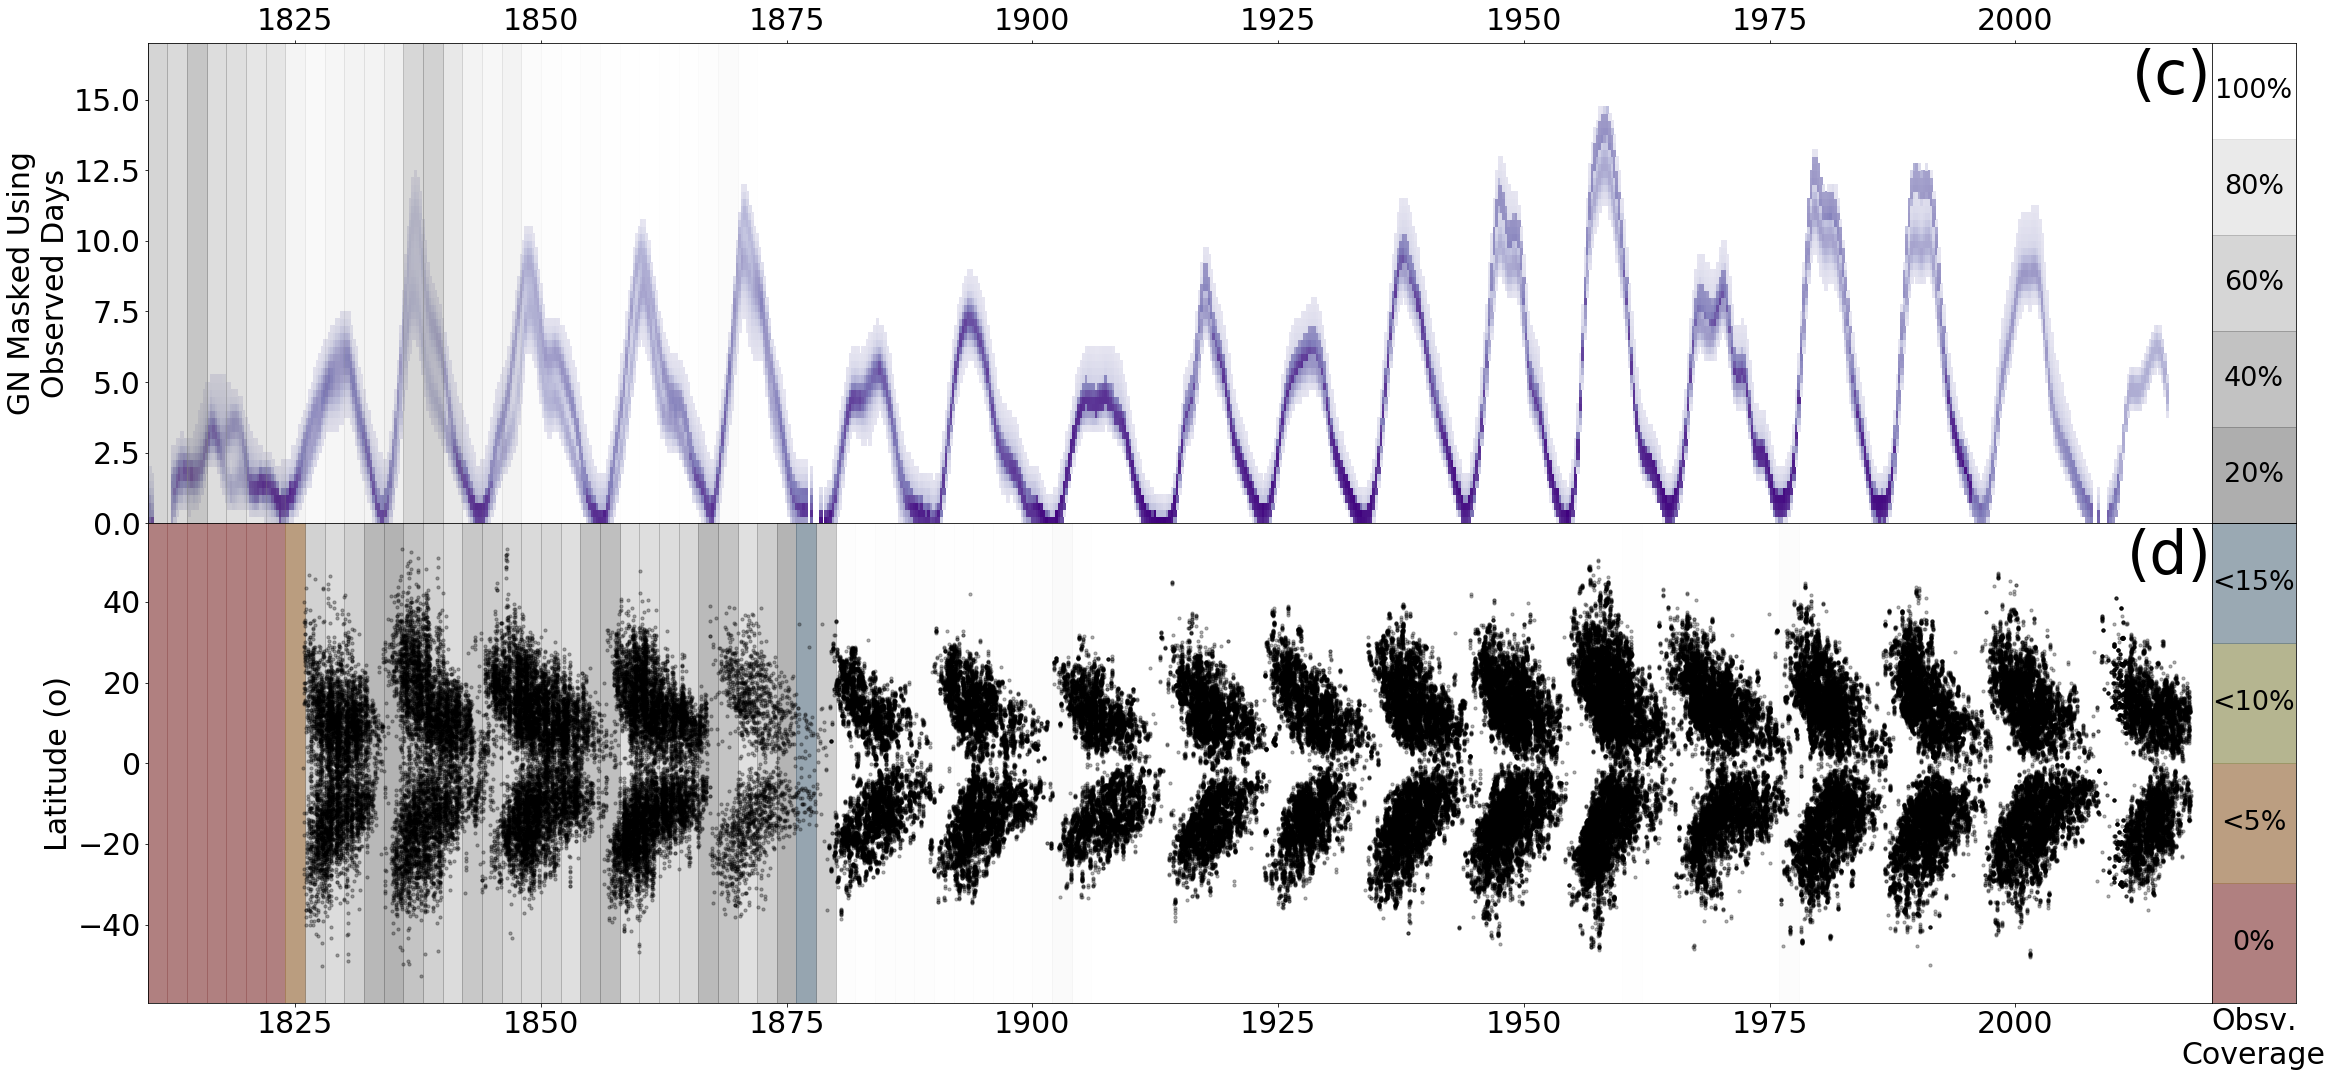

In [22]:
plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 8600   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 2      # Number of vertical panels

# Padding
padv  = 300 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 600 #Horizontal padding in pixels at the edge of the figure
padh2 = 350 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppxx   = pxx/fszh
ppxy   = pxy/fszv
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
Y1 = 1810
Y2 = 2020

fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

ax1 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])

cmap = plt.get_cmap('Purples')
pch = ax1.pcolormesh(YrBl, GrpsBl, np.transpose(GrpsBM), alpha =1, cmap=cmap,edgecolors='None',vmin = -0.5, vmax = np.nanmax(GrpsBM))

# Plot transparency mask
for i in np.arange(0,CrvObsYr.shape[0]):
    if CrvObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(CrvObsCv[i]/0.05)])))]
    ax1.fill([CrvObsYr[i], CrvObsYr[i], CrvObsYr[i]+YrCum, CrvObsYr[i]+YrCum], [0, 17, 17, 0], color=clr, alpha = (1-CrvObsCv[i])*MaskMaxAl, zorder=2, edgecolor = 'none')

ax1.annotate('(c)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')    
    
ax1.set_xlim(left=Y1, right=Y2)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_ylabel('GN Masked Using\nObserved Days')

ax2 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

# Plot transparency mask
# Plot transparency mask
for i in np.arange(0,BfObsYr.shape[0]):
    if BfObsCv[i]==0:
        clr = color0
    else:
        clr = colorsMsk[(int(np.min([3,np.floor(BfObsCv[i]/0.05)])))]
    ax2.fill([BfObsYr[i], BfObsYr[i], BfObsYr[i]+YrCum, BfObsYr[i]+YrCum], [-60, 60, 60, -60], color=clr, alpha = (1-BfObsCv[i])*MaskMaxAl, zorder=0, edgecolor = 'none')
        
ax2.scatter(BflyAll['FRACYEAR'],BflyAll['LATITUDE'],MZ,alpha=0.3,color='k')

ax2.annotate('(d)',xy=(1, 0.99),xycoords='axes fraction',fontsize=60,va='top', ha='right')

ax2.set_xlim(left=Y1, right=Y2)
ax2.set_ylim(top=59.5, bottom=-59.5)
ax2.set_ylabel('Latitude (o)');
# ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')

# Add Colorbar
axcb3  = fig.add_axes([ppadh+ppxx, ppadv, ppadh2, ppxy])

axcb3.fill([0,0,1,1], [0, 1, 1, 0], color=color0, alpha = MaskMaxAl, edgecolor = 'none')
axcb3.annotate('0%', xy = (0.5, 0.5), horizontalalignment='center', verticalalignment='center',
               fontsize=27,zorder=3, )
for i in range(1,4):
    clr = colorsMsk[i-1]
    axcb3.fill([0,0,1,1], [i, i+1, i+1, i], color=clr, alpha = (1-i/20)*MaskMaxAl, edgecolor = 'none')
    axcb3.annotate('<'+str(5*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb3.set_ylim(bottom = 0, top = 4)
axcb3.set_xlim(left=0, right=1)    

axcb3.set_xticks([])
axcb3.set_yticks([])
axcb3.set_xlabel('Obsv.\nCoverage')


# Add Colorbar
axcb2  = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppadh2, ppxy])
for i in range(1,6):
    axcb2.fill([0,0,1,1], [i, i+1, i+1, i], color=(0.5,0.5,0.5), alpha = (1-i/5)*MaskMaxAl, edgecolor = 'none')
    axcb2.annotate(str(20*i)+'%', xy = (0.5, i+0.5), horizontalalignment='center', verticalalignment='center',
                   fontsize=27,zorder=3, )

axcb2.set_ylim(bottom = 1, top = 6)
axcb2.set_xlim(left=0, right=1)    

axcb2.set_xticks([])
axcb2.set_yticks([])

fig.savefig('S2_Bfly_GN_Coverage_2.png',dpi=figDPI)